# **Part 2 | Multi-Factor Analysis**
*An Analysis of Fama and French 5 Faktor Model with Momentum and ESG Factor*

In [1]:
pip install great_tables

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 4.5 MB/s eta 0:00:00


In [2]:
#General Imports
import pandas as pd
import numpy as np
import os
import warnings
import ast #Used to read list of stocks in string as a list

#Plotting
from matplotlib.ticker import FuncFormatter, PercentFormatter
import matplotlib.dates as mdates
from matplotlib.dates import YearLocator, DateFormatter
from matplotlib import cm
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import seaborn as sns
from great_tables import GT, md, style, loc

#Working with Data
from functools import reduce #Get Monthly Data
from datetime import datetime, timedelta
import datetime as dt
from pandas.tseries.offsets import MonthEnd

#Estimation
import statsmodels.api as sm #Regression
from scipy import stats #Correlation
from scipy.stats import kendalltau, spearmanr, pearsonr #Kendal Tau

#Other Stuff
from IPython.display import display, Markdown  # For Markdown rendering

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

## **1. Data Collection**

### **1.1 Import ESG Data**

#### **1.11 Import ESG Factor**

In [3]:
esg_data = pd.read_csv("__data/esg_factor.csv", delimiter = ",") #Importing ESG Factor Data

In [4]:
esg_data_subsetted = esg_data.rename(columns={"Average_Return_High": "return_high_esg", "Average_Return_Low": "return_low_esg"})
esg_data_subsetted = esg_data_subsetted[["Date", "return_high_esg", "return_low_esg", "ESG_Factor"]]

esg_data_subsetted["Date"] = pd.to_datetime(esg_data["Date"])
esg_data_subsetted['Date'] = esg_data_subsetted["Date"].dt.date

In [5]:
esg_data.head()

,Date,Average_Return_High,Count_High,MCap_Total_High,MCap_Average_High,Average_Return_Low,Count_Low,MCap_Total_Low,MCap_Average_Low,ESG_Factor,ESG_Factor_Index_Average
0,2009-12-31,0.038894,154,6110.540896,39.678837,0.057903,154,908.712776,6.017965,0.019009,NaN
1,2010-01-31,-0.033412,156,5988.273673,38.386370,-0.030241,156,912.673663,5.965187,0.003171,NaN
2,2010-02-28,0.043410,156,6176.713433,39.594317,0.054302,156,963.517698,6.297501,0.010892,NaN
3,2010-03-31,0.069097,156,6533.051561,41.878536,0.070676,156,1005.762128,6.573609,0.001579,NaN
4,2010-04-30,0.025750,156,6633.206082,42.520552,0.045017,156,1022.315223,6.681799,0.019267,NaN


### **1.2 Importing Single Stock Data**

In [6]:
#Imports Stock Returns
stock_returns = pd.read_excel("__data/Stock_Return_Data_Wide_Format.xlsx", "ReturnTotal")

In [7]:
#Divides Stock Return values by 100 to get decimal values
stock_returns.loc[:, stock_returns.columns != "Date"] = stock_returns.loc[:, stock_returns.columns != "Date"].apply(lambda x: x / 100)

In [8]:
stock_returns["Date"] = pd.to_datetime(stock_returns["Date"])

In [9]:
stock_returns.tail()

,Date,A.N,AA.N,AAL.OQ,AAON.OQ,AAP.N,AAPL.OQ,AAT.N,ABBV.N,ABCB.N,...,YETI.N,YOU.N,YUM.N,ZBH.N,ZBRA.OQ,ZD.OQ,ZI.OQ,ZION.OQ,ZTS.N,ZWS.N
185,2024-06-30,-0.005981,-0.101423,-0.014783,0.163717,-0.103482,0.095553,0.044880,0.063756,0.011011,...,-0.063574,0.113823,-0.036164,-0.055398,-0.010918,-0.044437,0.039902,0.004168,0.022411,-0.061003
186,2024-07-31,0.092844,-0.169432,-0.060900,0.014787,0.003973,0.054411,0.184987,0.090424,0.239588,...,0.083879,0.141101,0.002793,0.025984,0.136795,-0.130245,-0.110415,0.191377,0.041036,0.104082
187,2024-08-31,0.010750,-0.025335,-0.001880,0.078843,-0.284541,0.032345,0.027526,0.059303,0.012153,...,-0.024909,0.423419,0.020794,0.036911,-0.016544,0.020677,-0.129401,-0.032311,0.019162,0.001645
188,2024-09-30,0.038903,0.201869,0.058380,0.130130,-0.139484,0.017467,-0.006791,0.005960,0.014766,...,0.017609,0.094090,0.035503,-0.062966,0.072210,-0.004297,0.043478,-0.047215,0.064799,0.108233
189,2024-10-31,-0.120960,0.041676,0.192171,0.059162,-0.078540,-0.030429,0.008608,0.040698,-0.006411,...,-0.141847,0.109837,-0.061198,-0.009541,0.031459,-0.049116,0.070736,0.102499,-0.082752,0.004452


### **1.4 Importing Momentum Factor Data**

In [10]:
def prepMomentumData(data, suffix):

  data_adj = data.copy()

  data_adj["date"] = pd.to_datetime(data_adj["date"], errors='coerce')
  data_adj["date"] = data_adj["date"].dt.date

  data_adj = data_adj.rename(columns={'date': 'Date'})
  data_adj = data_adj.rename(columns={'ret': f"Mom_{suffix}_Factor"})

  data_adj = data_adj[["Date", f"Mom_{suffix}_Factor"]]

  return data_adj

In [11]:
#Importing Residual Momentum Data
res_mom_12_1 = pd.read_csv('__data/[usa]_[resff3_12_1]_[monthly]_[ew].csv', delimiter = ",")
res_mom_6_1 = pd.read_csv('__data/[usa]_[resff3_6_1]_[monthly]_[ew].csv', delimiter = ",")

#Importing Price Momentum Data
price_mom_3_1 = pd.read_csv('__data/[usa]_[ret_3_1]_[monthly]_[ew].csv', delimiter = ",")
price_mom_6_1 = pd.read_csv('__data/[usa]_[ret_6_1]_[monthly]_[ew].csv', delimiter = ",")
price_mom_9_1 = pd.read_csv('__data/[usa]_[ret_9_1]_[monthly]_[ew].csv', delimiter = ",")
price_mom_12_1 = pd.read_csv('__data/[usa]_[ret_12_1]_[monthly]_[ew].csv', delimiter = ",")
price_mom_12_7 = pd.read_csv('__data/[usa]_[ret_12_7]_[monthly]_[ew].csv', delimiter = ",")

In [12]:
res_mom_12_1 = prepMomentumData(res_mom_12_1, "Res_12_1")
res_mom_6_1 = prepMomentumData(res_mom_6_1, "Res_6_1")

price_mom_3_1 = prepMomentumData(price_mom_3_1, "Price_3_1")
price_mom_6_1 = prepMomentumData(price_mom_6_1, "Price_6_1")
price_mom_9_1 = prepMomentumData(price_mom_9_1, "Price_9_1")
price_mom_12_1 = prepMomentumData(price_mom_12_1, "Price_12_1")
price_mom_12_7 = prepMomentumData(price_mom_12_7, "Price_12_7")

In [13]:
res_mom_12_1.tail()

,Date,Mom_Res_12_1_Factor
843,2023-08-31,0.021640
844,2023-09-30,0.006053
845,2023-10-31,0.004473
846,2023-11-30,0.047826
847,2023-12-31,0.000407


### **1.5 Importing Fama and French Data**

In [14]:
ff5 = pd.read_csv("__data/F-F_Research_Data_5_Factors_2x3.csv", skiprows=2, index_col=0)


In [15]:
ff5 = pd.read_csv("__data/F-F_Research_Data_5_Factors_2x3.csv", skiprows=3, index_col=0)

# Convert the index to datetime
ff5.index = pd.to_datetime(ff5.index, format='%Y%m') + MonthEnd(0)

# Remove any potential whitespace in column names
ff5.columns = ff5.columns.str.strip()

# Convert data to numeric, replacing any non-numeric values with NaN
for col in ff5.columns:
    ff5[col] = pd.to_numeric(ff5[col], errors='coerce')
    ff5[col] = ff5[col] / 100 #Divide by 100 to get actual "returns" as decimals

# Drop observations older than 2009-01-01
ff5 = ff5[ff5.index >= '2009-01-01']

# Create a new "Date" column from the index
ff5["Date"] = ff5.index
ff5['Date'] = ff5["Date"].dt.date

# Sort columns and drop index
ff5 = ff5[['Date', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']]
ff5.reset_index(drop=True, inplace=True)

# Display the first few rows of the resulting dataframe
ff5.head()

,Date,Mkt-RF,SMB,HML,RMW,CMA,RF
0,2009-01-31,-0.0812,-0.0214,-0.1129,0.0018,-0.0116,0.0000
1,2009-02-28,-0.1010,-0.0133,-0.0695,0.0120,-0.0102,0.0001
2,2009-03-31,0.0895,0.0067,0.0347,-0.0252,-0.0225,0.0002
3,2009-04-30,0.1018,0.0713,0.0536,0.0131,0.0012,0.0001
4,2009-05-31,0.0521,-0.0232,0.0028,-0.0078,-0.0216,0.0000


### **1.6 Merging Data**

In [16]:
# Merge all datasets on the Date column

momentum_factors = [res_mom_12_1, res_mom_6_1, price_mom_3_1, price_mom_6_1, price_mom_9_1, price_mom_12_1, price_mom_12_7]
dataframes = [ff5, esg_data_subsetted] + momentum_factors + [stock_returns]

for df in dataframes:
    df["Date"] = pd.to_datetime(df["Date"])

#Merge data
data = reduce(lambda left, right: pd.merge(left, right, on = "Date"), dataframes)

# Display the first few rows and column names of the resulting dataframe
data.tail()

,Date,Mkt-RF,SMB,HML,RMW,CMA,RF,return_high_esg,return_low_esg,ESG_Factor,...,YETI.N,YOU.N,YUM.N,ZBH.N,ZBRA.OQ,ZD.OQ,ZI.OQ,ZION.OQ,ZTS.N,ZWS.N
164,2023-08-31,-0.0239,-0.0368,-0.0108,0.0342,-0.0237,0.0045,-0.033691,-0.033316,0.000375,...,0.172535,-0.080293,-0.055820,-0.137749,-0.106994,-0.080943,-0.295268,-0.060973,0.012866,-0.024564
165,2023-09-30,-0.0524,-0.0179,0.0145,0.0185,-0.0084,0.0043,-0.050018,-0.055720,-0.005702,...,-0.034635,-0.124195,-0.034318,-0.055914,-0.139922,-0.044411,-0.089900,-0.017183,-0.086767,-0.054018
166,2023-10-31,-0.0318,-0.0405,0.0019,0.0247,-0.0067,0.0047,-0.050401,-0.056359,-0.005957,...,-0.118208,-0.116597,-0.032656,-0.069595,-0.114573,-0.050714,-0.209756,-0.115792,-0.095442,-0.055675
167,2023-11-30,0.0883,-0.0011,0.0166,-0.0381,-0.0099,0.0044,0.094886,0.101317,0.006431,...,0.002822,0.309508,0.043727,0.113974,0.131548,0.055574,0.108796,0.168970,0.125287,0.115560
168,2023-12-31,0.0487,0.0733,0.0492,-0.0304,0.0130,0.0043,0.087025,0.119027,0.032002,...,0.214353,-0.031880,0.040701,0.048410,0.153388,0.052805,0.286708,0.231266,0.117168,-0.001019


In [17]:
#Len data
len(data)

169

## **2 Visualizing Factors**

### **2.1 Return Distributions**

In [18]:
def plotXReturnDistributions(data_list, column_names, labels, colors, title, x_label, y_label):

  plt.figure(figsize=(10, 6), dpi=100)

  for i in range(len(column_names)):
    data = data_list[i]
    column_name = column_names[i]

    sns.kdeplot(data[column_name], color = colors[i], label = labels[i], fill = False, alpha = 0.35)

  # Add labels and title
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title(title)

  # Add legend
  plt.legend(bbox_to_anchor = (1.05, 1), loc = "upper left", frameon = False)

  # Remove Grid
  plt.grid(visible = False)

  # Show plot
  plt.show()

**ESG data**

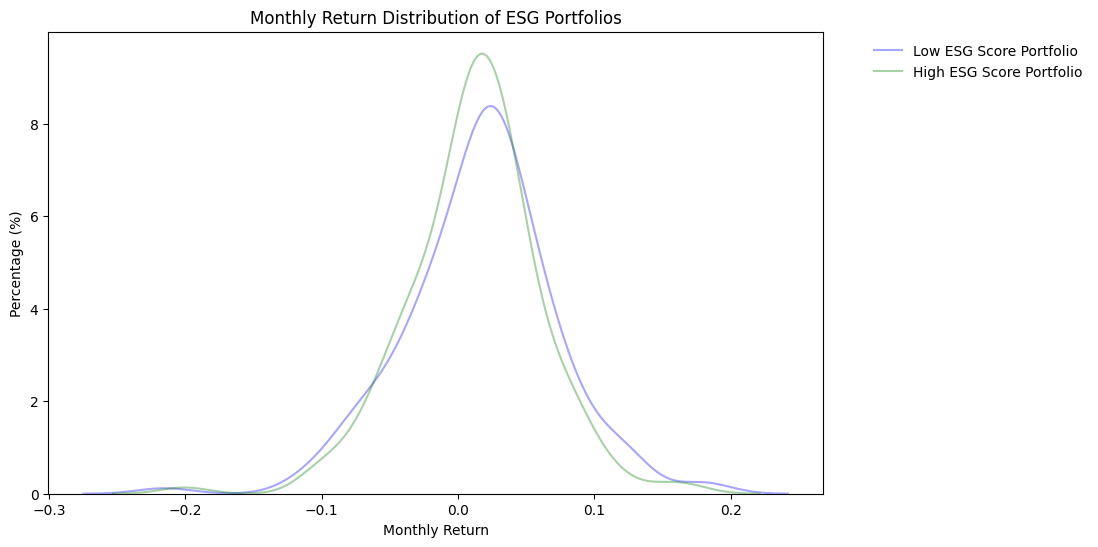

In [19]:
data_list = [data, data]
column_names = ["return_low_esg", "return_high_esg"]
labels = ["Low ESG Score Portfolio", "High ESG Score Portfolio"]
colors = ["blue", "green"]

plotXReturnDistributions(data_list, column_names, labels, colors,
                           title = "Monthly Return Distribution of ESG Portfolios",
                           x_label = "Monthly Return",
                           y_label = "Percentage (%)")

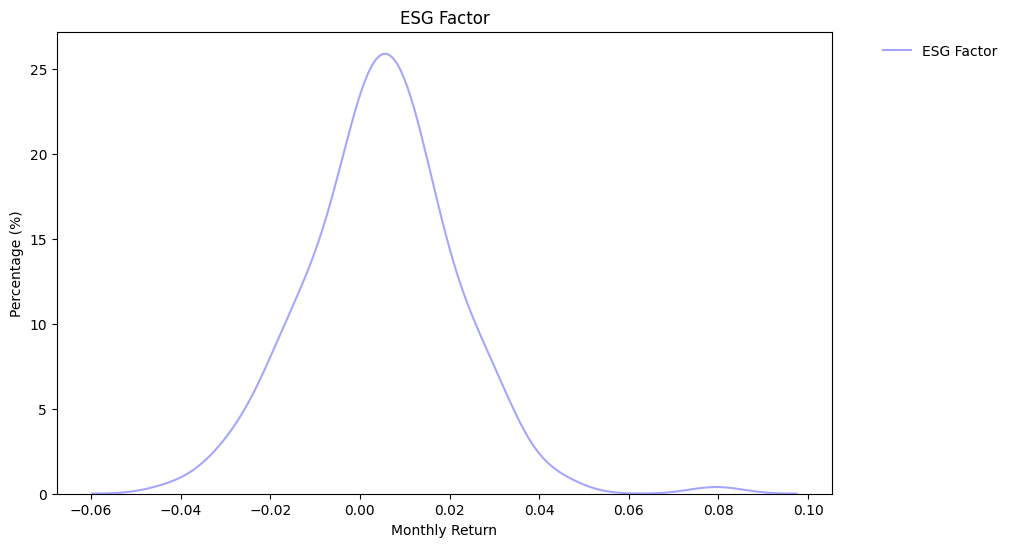

In [20]:
data_list = [data]
column_names = ["ESG_Factor"]
labels = ["ESG Factor"]
colors = ["blue"]

plotXReturnDistributions(data_list, column_names, labels, colors,
                           title = "ESG Factor",
                           x_label = "Monthly Return",
                           y_label = "Percentage (%)")

**Residual Momentum Factor**

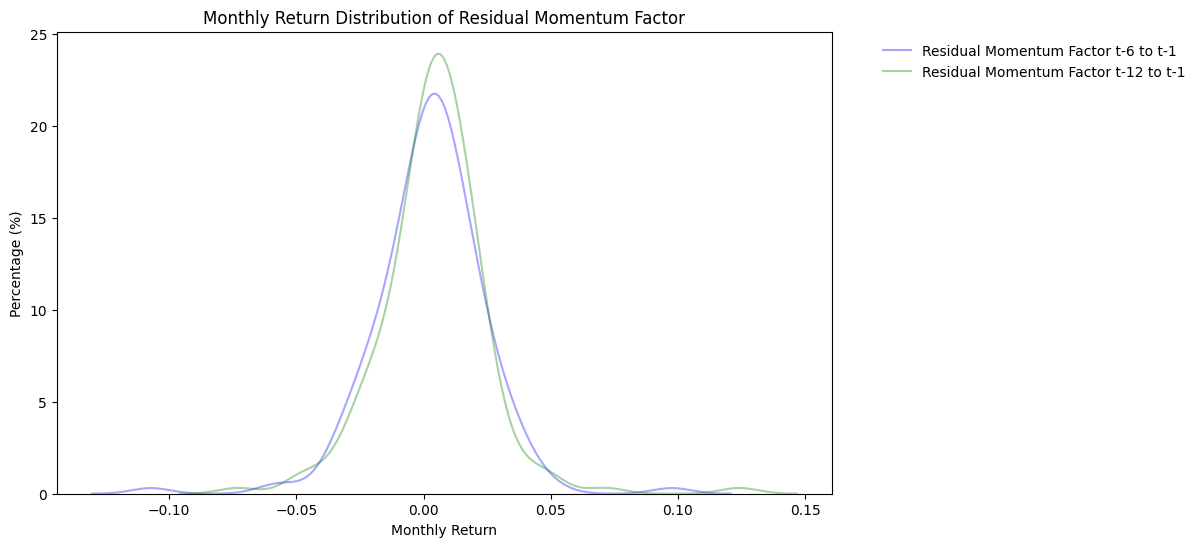

In [21]:
data_list = [data, data]
column_names = ["Mom_Res_6_1_Factor", "Mom_Res_12_1_Factor"]
labels = ["Residual Momentum Factor t-6 to t-1", "Residual Momentum Factor t-12 to t-1"]
colors = ["blue", "green"]

plotXReturnDistributions(data_list, column_names, labels, colors,
                           title = "Monthly Return Distribution of Residual Momentum Factor",
                           x_label = "Monthly Return",
                           y_label = "Percentage (%)")

**Price Momentum Factor**

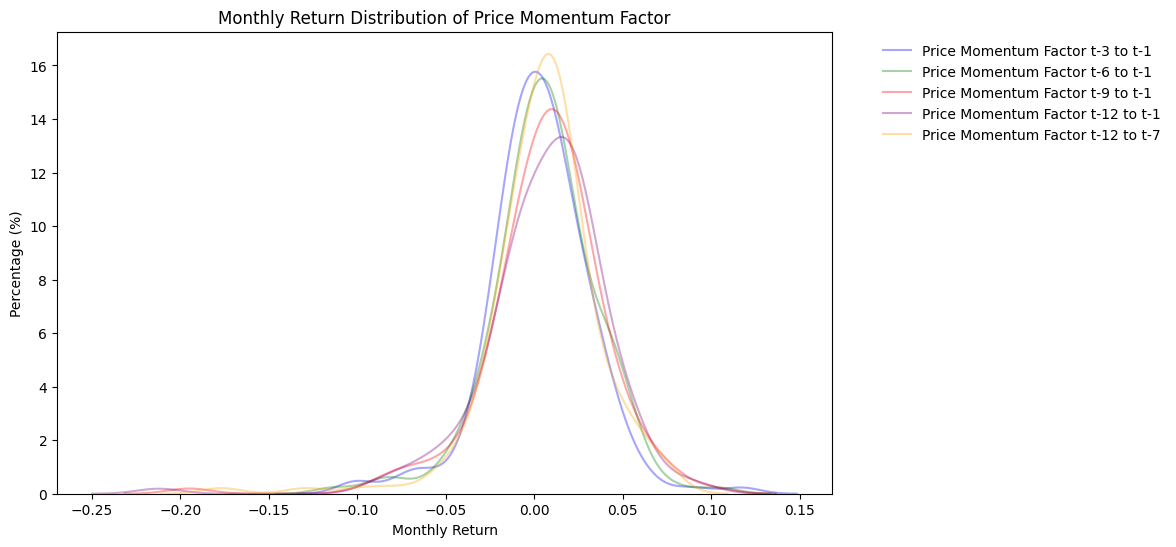

In [22]:
data_list = [data, data, data, data, data]

column_names = ["Mom_Price_3_1_Factor",
                "Mom_Price_6_1_Factor",
                "Mom_Price_9_1_Factor",
                "Mom_Price_12_1_Factor",
                "Mom_Price_12_7_Factor"]

labels = ["Price Momentum Factor t-3 to t-1",
          "Price Momentum Factor t-6 to t-1",
          "Price Momentum Factor t-9 to t-1",
          "Price Momentum Factor t-12 to t-1",
          "Price Momentum Factor t-12 to t-7"]

colors = ["blue", "green", "red", "purple", "orange"]

plotXReturnDistributions(data_list, column_names, labels, colors,
                           title = "Monthly Return Distribution of Price Momentum Factor",
                           x_label = "Monthly Return",
                           y_label = "Percentage (%)")

**Fama French 5 Factors**

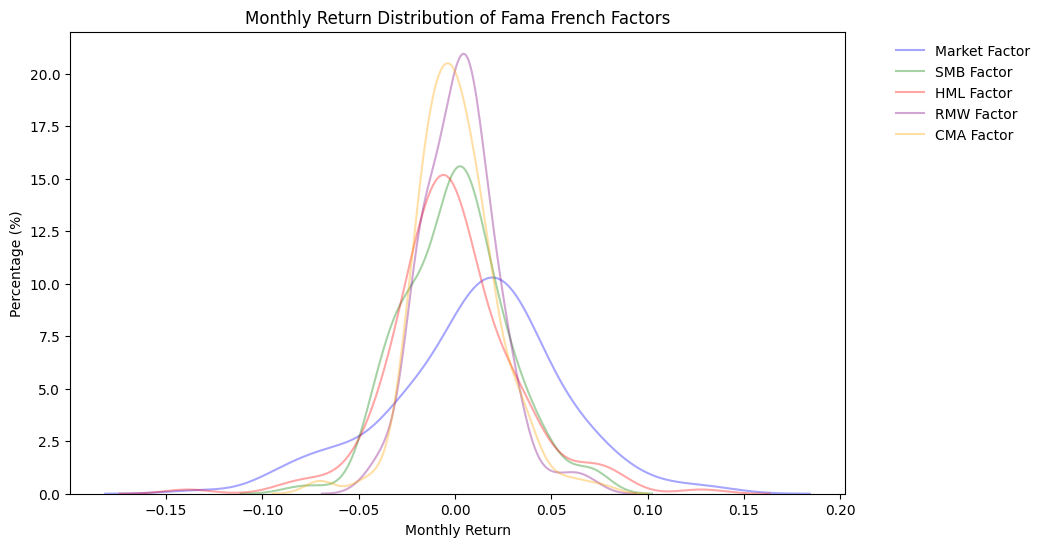

In [23]:
data_list = [data, data, data, data, data]

column_names = ["Mkt-RF", "SMB", "HML", "RMW", "CMA"]
labels = ["Market Factor", "SMB Factor", "HML Factor", "RMW Factor", "CMA Factor"]
colors = ["blue", "green", "red", "purple", "orange"]

plotXReturnDistributions(data_list, column_names, labels, colors,
                           title = "Monthly Return Distribution of Fama French Factors",
                           x_label = "Monthly Return",
                           y_label = "Percentage (%)")

### **2.2 Returns over Time**

In [24]:
def plotXReturnsOverTime(data_list, column_names, labels, title, x_label, y_label):

  plt.figure(figsize=(10, 6), dpi=100)

  for i in range(len(column_names)):
    data = data_list[i]
    column_name = column_names[i]

    sns.lineplot(data = data, x = "Date", y = column_name, label = labels[i])

  # Add labels and title
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title(title)

  # Add legend
  plt.legend(bbox_to_anchor = (1.05, 1), loc = "upper left", frameon = False)

  # Remove Grid
  plt.grid(visible = False)

  # Show plot
  plt.show()

**ESG Factor**

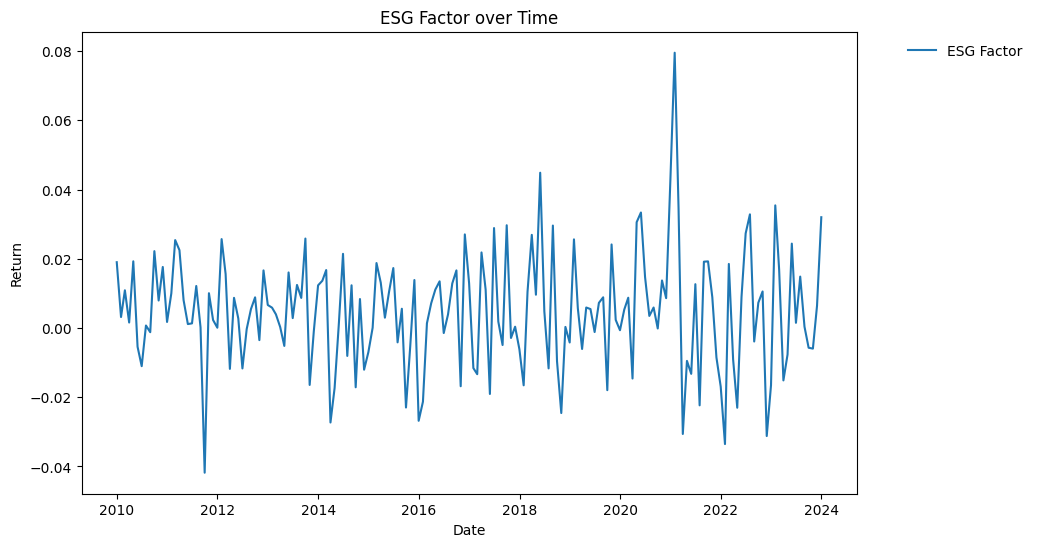

In [25]:
data_list = [data]
column_names = ["ESG_Factor"]
labels = ["ESG Factor"]

plotXReturnsOverTime(data_list, column_names, labels, "ESG Factor over Time", "Date", "Return")

**Momentum Factor**

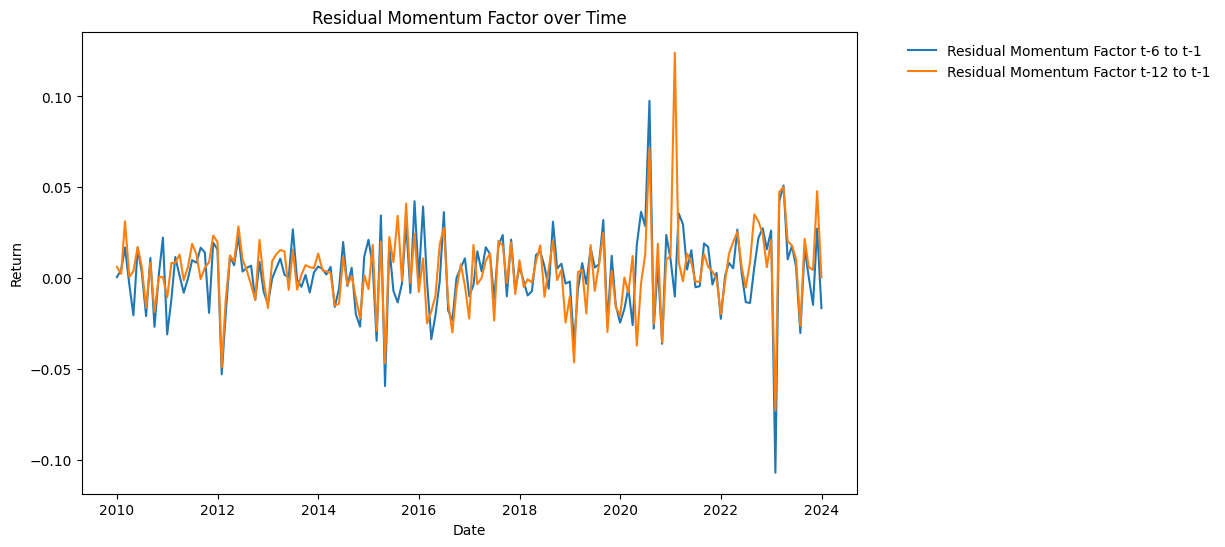

In [26]:
data_list = [data, data]
column_names = ["Mom_Res_6_1_Factor", "Mom_Res_12_1_Factor"]
labels = ["Residual Momentum Factor t-6 to t-1", "Residual Momentum Factor t-12 to t-1"]

plotXReturnsOverTime(data_list, column_names, labels, "Residual Momentum Factor over Time", "Date", "Return")

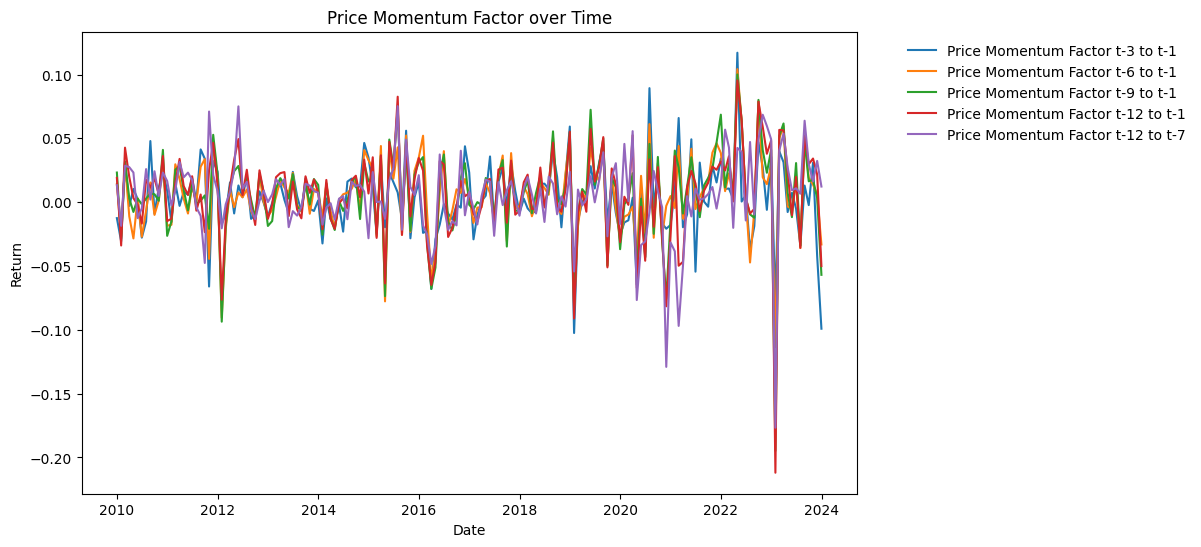

In [27]:
data_list = [data, data, data, data, data]

column_names = ["Mom_Price_3_1_Factor",
                "Mom_Price_6_1_Factor",
                "Mom_Price_9_1_Factor",
                "Mom_Price_12_1_Factor",
                "Mom_Price_12_7_Factor"]

labels = ["Price Momentum Factor t-3 to t-1",
          "Price Momentum Factor t-6 to t-1",
          "Price Momentum Factor t-9 to t-1",
          "Price Momentum Factor t-12 to t-1",
          "Price Momentum Factor t-12 to t-7"]

plotXReturnsOverTime(data_list, column_names, labels, "Price Momentum Factor over Time", "Date", "Return")

**Momentum & ESG Factor**

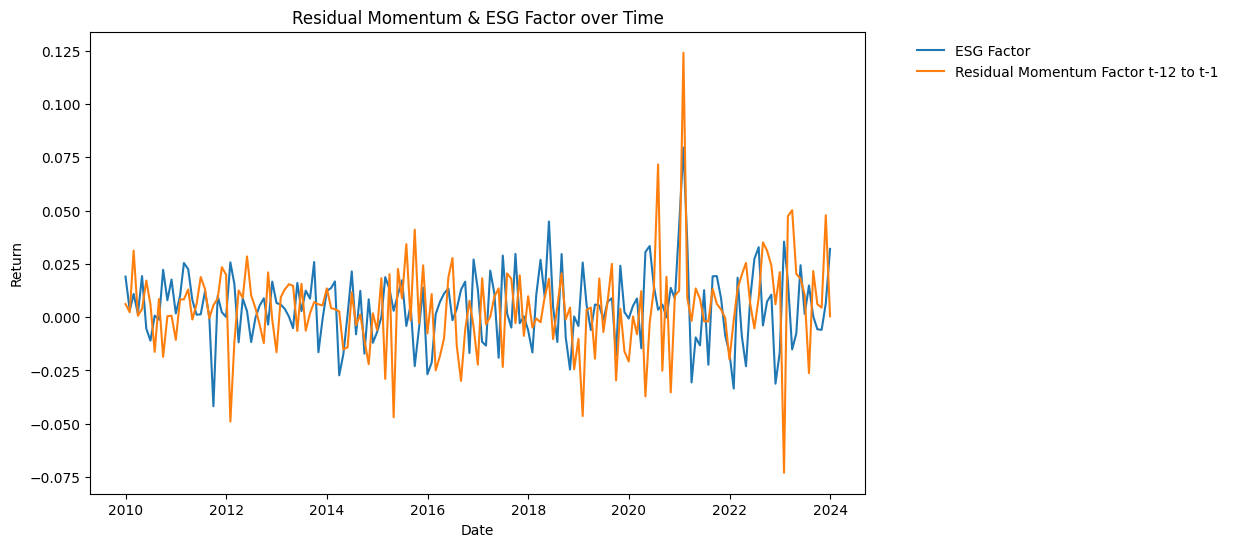

In [28]:
data_list = [data, data, data]
column_names = ["ESG_Factor", "Mom_Res_12_1_Factor"]
labels = ["ESG Factor", "Residual Momentum Factor t-12 to t-1"]

plotXReturnsOverTime(data_list, column_names, labels, "Residual Momentum & ESG Factor over Time", "Date", "Return")


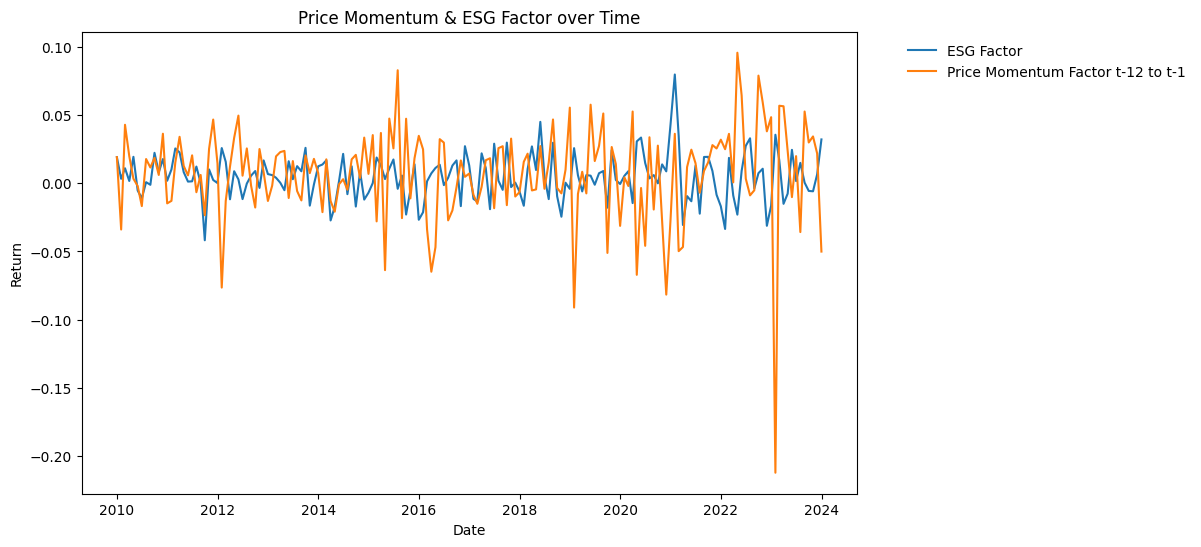

In [29]:
data_list = [data, data, data]
column_names = ["ESG_Factor", "Mom_Price_12_1_Factor"]
labels = ["ESG Factor", "Price Momentum Factor t-12 to t-1"]

plotXReturnsOverTime(data_list, column_names, labels, "Price Momentum & ESG Factor over Time", "Date", "Return")


## **3 Visualizing Correlation with Heatmap**

### **3.1 Plotting Functions**

In [30]:
def plotHeatmap(corr_matrix, title):
  plt.figure(figsize=(12, 10))

  #Plot Heatmap
  sns.heatmap(corr_matrix, annot = True, cmap = 'coolwarm', vmin = -1, vmax = 1, center = 0, fmt='.2f')

  # Move x-axis to top
  plt.gca().xaxis.set_ticks_position('top')
  plt.gca().xaxis.set_label_position('top')

  #Rotate labels on X-Axis
  plt.xticks(rotation = 60)

  #Add title
  plt.title(title)
  plt.show()

In [31]:
#Calculating Correlation Coefficients
momentum_factor_columns = ["Mom_Res_12_1_Factor",
                           "Mom_Res_6_1_Factor",
                           "Mom_Price_3_1_Factor",
                           "Mom_Price_6_1_Factor",
                           "Mom_Price_9_1_Factor",
                           "Mom_Price_12_1_Factor",
                           "Mom_Price_12_7_Factor"]

factor_columns = ["Mkt-RF", "SMB", "HML", "RMW", "CMA", "ESG_Factor"] + momentum_factor_columns

#Columns of dataframes
columns = data[factor_columns].columns

### **3.2 Calculate & Plot Pearson Correlation Coefficient**

In [32]:
#Correlation & P-Value Matrices
corr_matrix_pearson = pd.DataFrame(index=columns, columns=columns, dtype=float)
pval_matrix_pearson = pd.DataFrame(index=columns, columns=columns, dtype=float)

for col1 in columns:
    for col2 in columns:

        #Calculates correlation coefficient and p-value
        corr, pval = pearsonr(data[col1], data[col2])

        #Adds values to dataframes
        corr_matrix_pearson.loc[col1, col2] = corr
        pval_matrix_pearson.loc[col1, col2] = pval

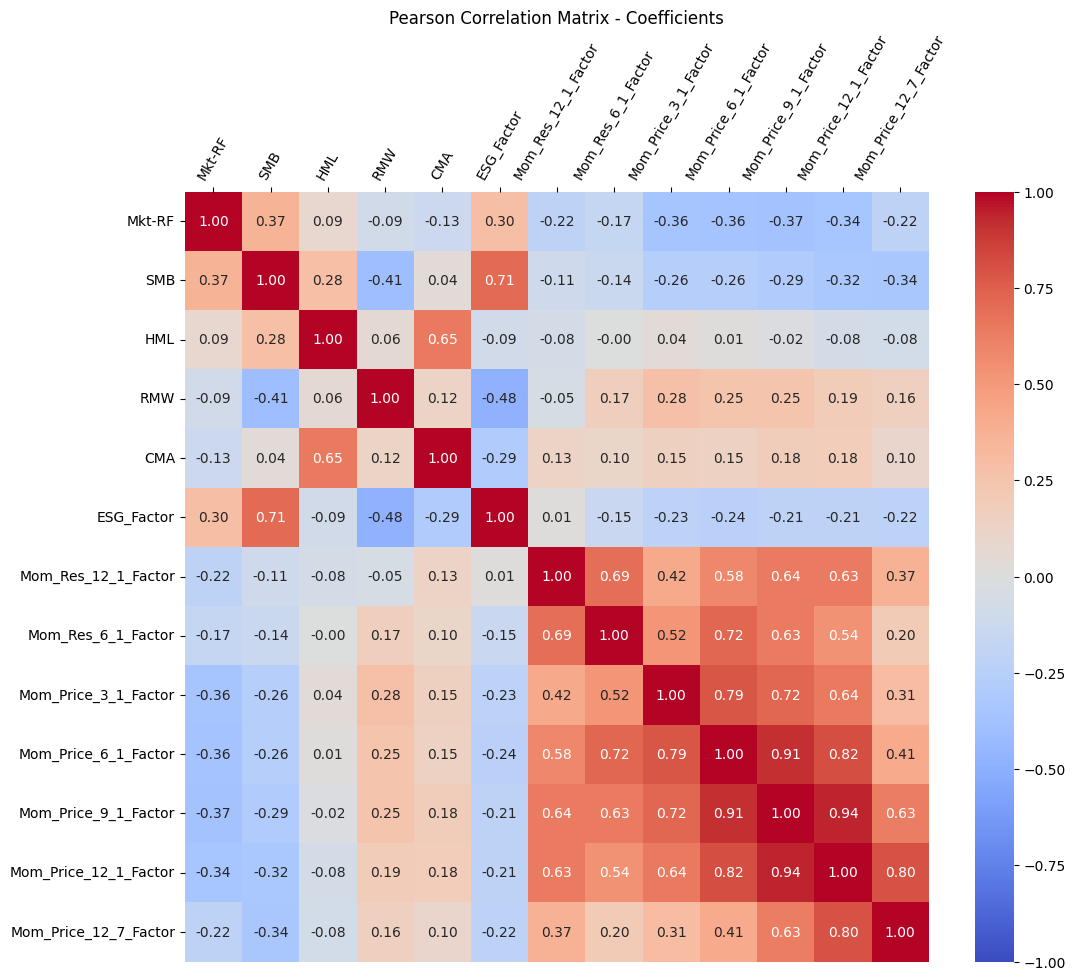

In [33]:
plotHeatmap(corr_matrix_pearson, "Pearson Correlation Matrix - Coefficients")

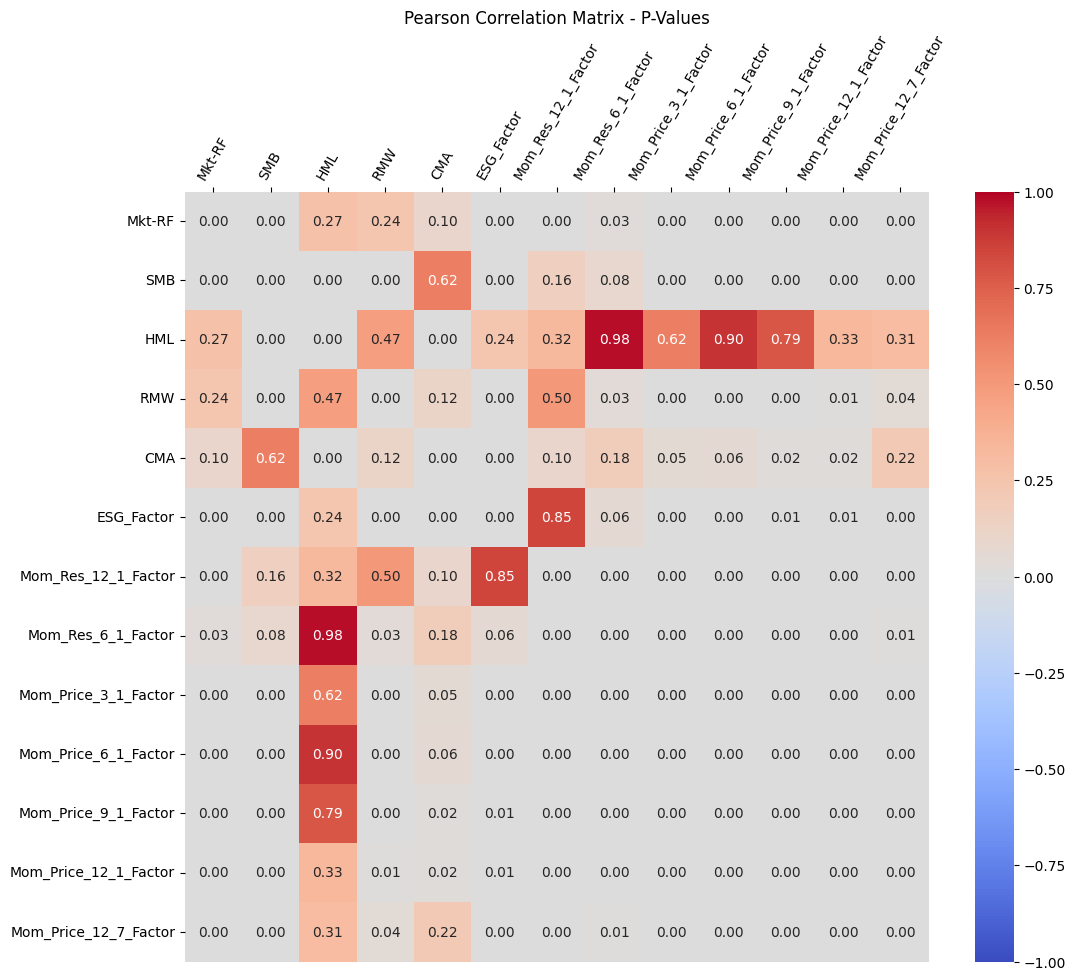

In [34]:
plotHeatmap(pval_matrix_pearson, "Pearson Correlation Matrix - P-Values")

### **3.3 Calculate & Plot Spearman Rank Correlation**

In [35]:
#Correlation & P-Value Matrices
corr_matrix_spearman = pd.DataFrame(index=columns, columns=columns, dtype=float)
pval_matrix_spearman = pd.DataFrame(index=columns, columns=columns, dtype=float)

for col1 in columns:
    for col2 in columns:

        #Calculates correlation coefficient and p-value
        corr, pval = spearmanr(data[col1], data[col2])

        #Adds values to dataframes
        corr_matrix_spearman.loc[col1, col2] = corr
        pval_matrix_spearman.loc[col1, col2] = pval

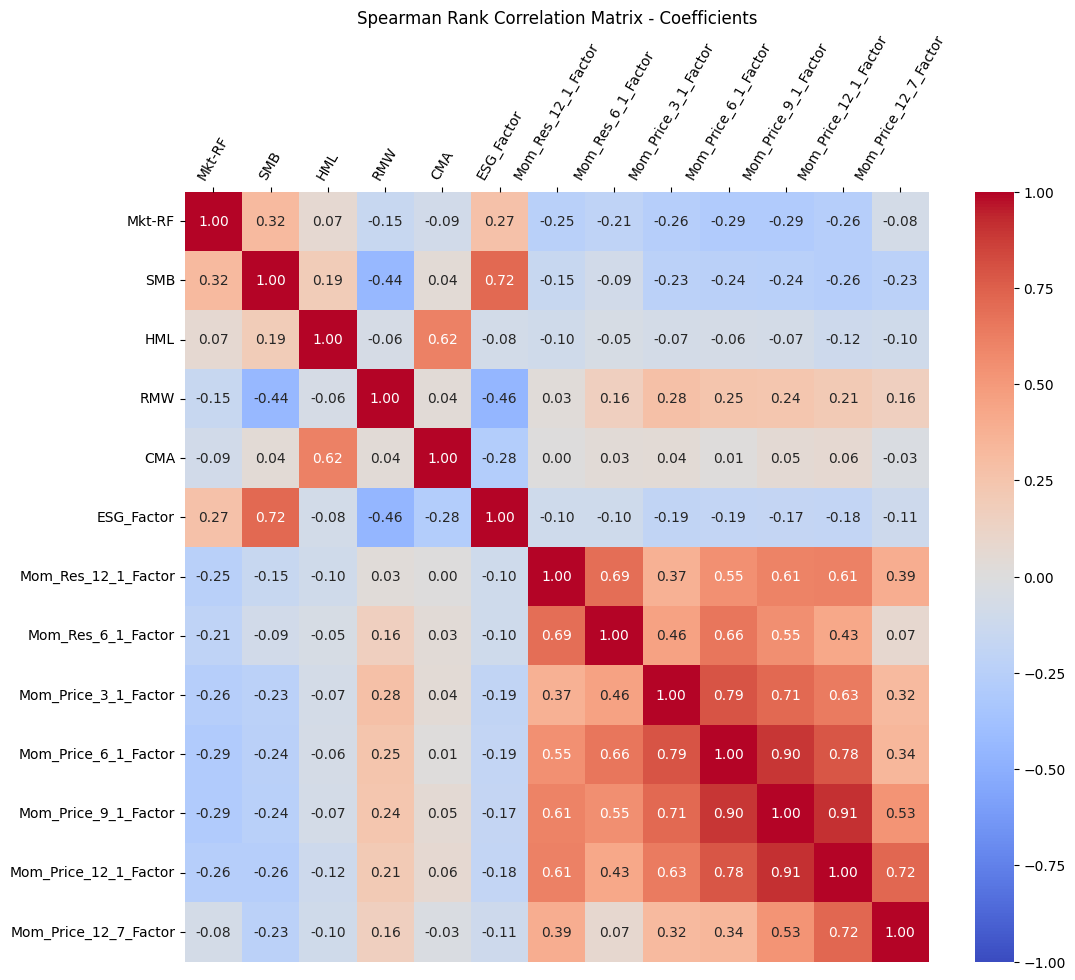

In [36]:
plotHeatmap(corr_matrix_spearman, "Spearman Rank Correlation Matrix - Coefficients")

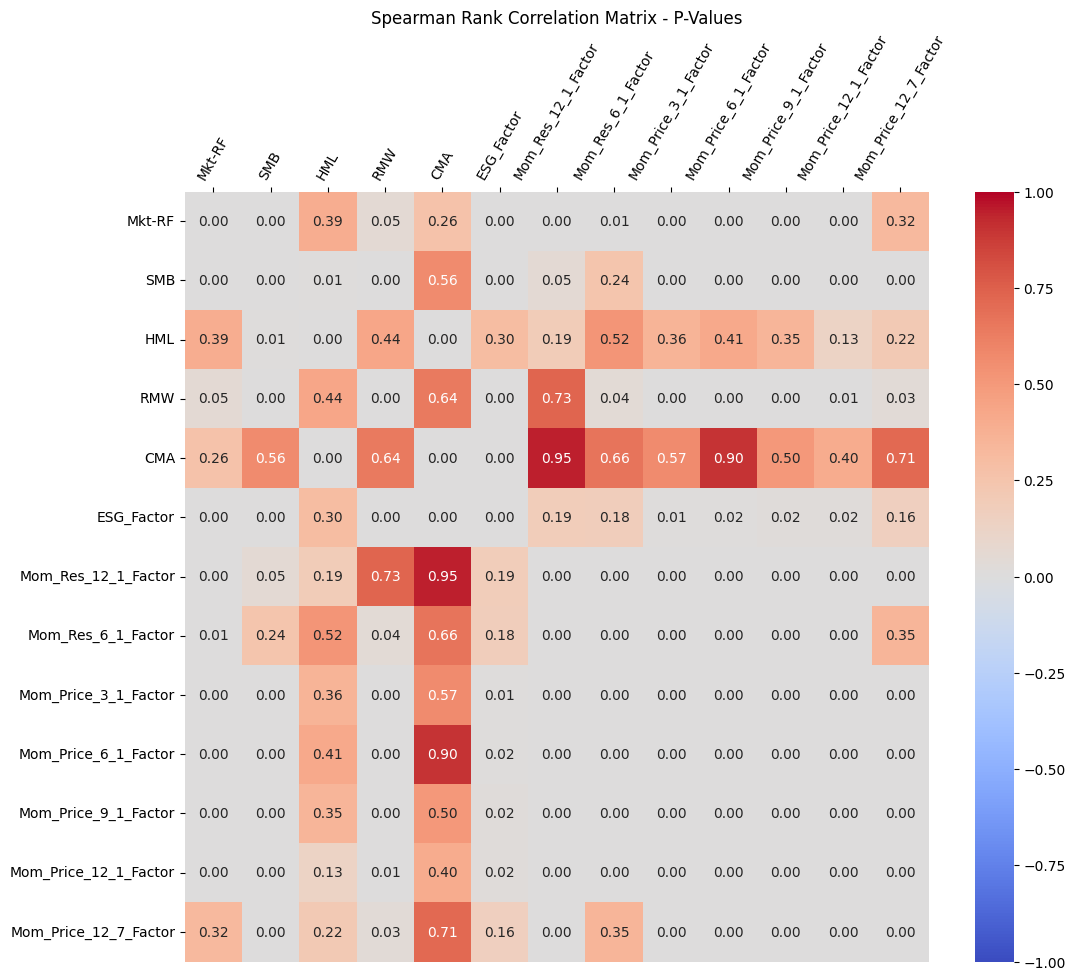

In [37]:
plotHeatmap(pval_matrix_spearman, "Spearman Rank Correlation Matrix - P-Values")

### **3.3 Calculate & Plot Kendall Tau**

In [38]:
n_cols = len(factor_columns)

#Initialize empty matrix
kendall_corr_matrix = np.zeros((n_cols, n_cols))
kendall_pval_matrix = np.zeros((n_cols, n_cols))

#Counting variable for rows
row = 0

#Loop over all coefficients
for factor_1 in factor_columns:

  #Counting variable for column
  column = 0

  #Loop over all coefficients again
  for factor_2 in factor_columns:

    #Calculate Kendall Tau Correlation
    tau, pval = kendalltau(data[factor_1], data[factor_2])

    kendall_corr_matrix[row, column] = tau
    kendall_pval_matrix[row, column] = pval

    column = column + 1

  row = row + 1

#Convert to a DataFrame for easier plotting
kendall_tau_df = pd.DataFrame(kendall_corr_matrix, columns = factor_columns, index = factor_columns)
kendall_pval_df = pd.DataFrame(kendall_pval_matrix, columns = factor_columns, index = factor_columns)

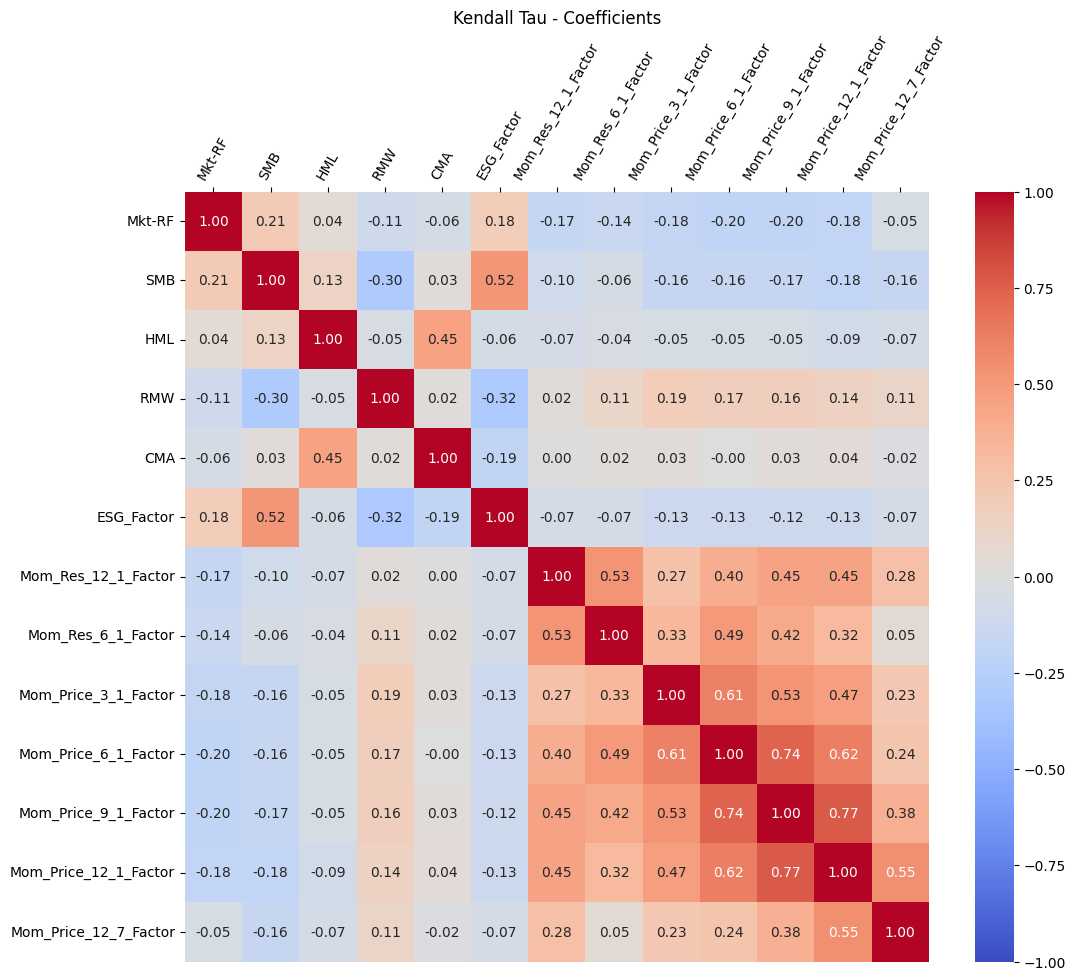

In [39]:
plotHeatmap(kendall_tau_df, "Kendall Tau - Coefficients") #rank-based relationships

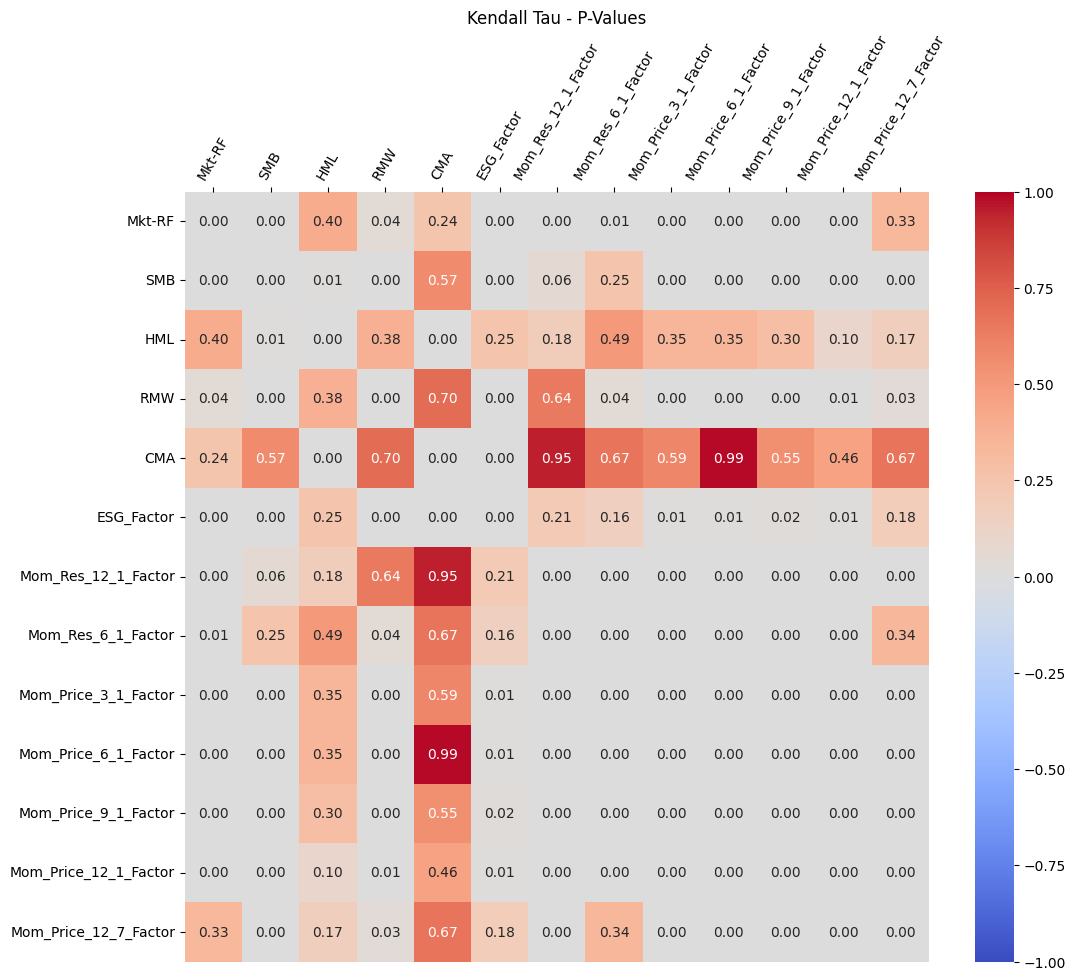

In [40]:
plotHeatmap(kendall_pval_df, "Kendall Tau - P-Values") #rank-based relationships

## **4. Fama-Macbeth Regression for Entire Market**

### **4.1 Regression Functions**

In [41]:
def getMomentumFactorColumns():
  momentum_factor_columns = ["Mom_Res_12_1_Factor",
                           "Mom_Res_6_1_Factor",
                           "Mom_Price_3_1_Factor",
                           "Mom_Price_6_1_Factor",
                           "Mom_Price_9_1_Factor",
                           "Mom_Price_12_1_Factor",
                           "Mom_Price_12_7_Factor"]

  return momentum_factor_columns

In [42]:
def getNonMomentumFactorColumns():
  return ["Mkt-RF", "SMB", "HML", "RMW", "CMA", "ESG_Factor"]

In [43]:
def getStocks(regression_data):

  momentum_factor_columns = getMomentumFactorColumns()
  non_momentum_factor_columns = getNonMomentumFactorColumns()

  stocks = [col for col in regression_data.columns if col not in (non_momentum_factor_columns
                                                                  + ["RF"]
                                                                  + ["return_high_esg", "return_low_esg", "Date"]
                                                                  + momentum_factor_columns)]
  return stocks

In [44]:
def runFirstStageRegression(regression_data):

  momentum_factor_columns = getMomentumFactorColumns()
  stocks = getStocks(regression_data)

  models_betas = []

  #Run regression with each momentum factor separately
  for i in range(len(momentum_factor_columns)):

    factor_columns = getNonMomentumFactorColumns() + [momentum_factor_columns[i]]

    #Stocks are all columns except
    betas = pd.DataFrame(columns=["Stock", "Intercept"] + factor_columns)

    #Run Regression
    for stock in stocks:

      #Drop missing values
      current_stock_data = regression_data[["RF"] + factor_columns + [stock]].dropna()

      #Make sure regression is only done if there are at least 32 data-points.
      if len(current_stock_data) >= 32:

        Y = current_stock_data[stock] - current_stock_data["RF"] #Computes Excess Return
        X = current_stock_data[factor_columns] #Sets Factors
        X = sm.add_constant(X) #Adds constant to model

        model = sm.OLS(Y, X).fit() #Runs regression

        coefficients = model.params #Gets betas
        row = [stock] + coefficients.tolist()

        betas.loc[len(betas)] = row #Add betas

    models_betas.append(betas)

  return models_betas

In [45]:
def getSecondStageDataFrames(regression_data, models_betas):
  #Calculate average excess return
  average_excess_returns = {
      stock: (regression_data[stock] - regression_data["RF"]).mean()
      for stock in getStocks(regression_data)
  }

  #Create a dataframe with average excess returns
  average_excess_df = pd.DataFrame(list(average_excess_returns.items()), columns=["Stock", "Avg_Excess_Return"])

  #Merge with betas table

  stage_2_dataframes = []

  for i in range(len(models_betas)):

    stage_2_data = models_betas[i].merge(average_excess_df, on = "Stock")
    stage_2_dataframes.append(stage_2_data)

  return stage_2_dataframes

In [46]:
def runSecondStageRegression(stage_2_dataframes):
  risk_premium_estimations = []
  risk_premium_p_values = []

  #Performs second stage regression
  for i in range(len(stage_2_dataframes)):

    stage_2_data = stage_2_dataframes[i]

    stage_2_factor_columns = getNonMomentumFactorColumns() + [getMomentumFactorColumns()[i]]

    stage_2_Y = stage_2_data["Avg_Excess_Return"] #Computes Excess Return
    stage_2_X = stage_2_data[stage_2_factor_columns]
    stage_2_X = sm.add_constant(stage_2_X) #Adds constant to model

    stage_2_model = sm.OLS(stage_2_Y, stage_2_X).fit(cov_type='HC3') #Runs regression with Heteroskedasticity robust std. errors

    risk_premium = stage_2_model.params
    p_values = stage_2_model.pvalues

    #Adds monthly risk premiums and p-values to table
    risk_premium_estimation = pd.DataFrame({
        f"Model {i + 1}": round(risk_premium * 100, 4)
    })

    risk_premium_p_value = pd.DataFrame({
        f"Model {i + 1}": round(p_values, 4)
    })

    risk_premium_estimation = risk_premium_estimation.reset_index().rename(columns={"index": "Factors"})
    risk_premium_p_value = risk_premium_p_value.reset_index().rename(columns={"index": "Factors"})

    risk_premium_estimations.append(risk_premium_estimation)
    risk_premium_p_values.append(risk_premium_p_value)

  return risk_premium_estimations, risk_premium_p_values


### **4.2 Run Regressions**

In [47]:
#Copy Data for Regression to prevent altering original Data
regression_data = data.copy()

In [48]:
models_betas = runFirstStageRegression(regression_data)

In [49]:
stage_2_dataframes = getSecondStageDataFrames(regression_data, models_betas)

In [50]:
stage_2_dataframes[0].head()

,Stock,Intercept,Mkt-RF,SMB,HML,RMW,CMA,ESG_Factor,Mom_Res_12_1_Factor,Avg_Excess_Return
0,A.N,0.003421,1.268771,0.161461,-0.170102,-0.358717,0.132905,-0.448613,0.014247,0.014073
1,AA.N,0.025362,1.908390,3.569494,0.469840,0.419338,-0.107162,-4.129369,0.145812,0.020151
2,AAL.OQ,0.001835,1.272168,1.777834,0.485549,-0.135397,-0.452438,-1.955778,0.189871,0.002053
3,AAON.OQ,0.010247,0.857548,1.083531,-0.125856,0.273806,-0.117822,-0.365781,0.649947,0.021363
4,AAP.N,-0.004772,0.803482,0.677841,0.056683,1.015601,0.710931,0.344750,-0.427630,0.007165


In [51]:
risk_premium_estimations, risk_premium_p_values = runSecondStageRegression(stage_2_dataframes)

### **4.3 Plots Risk Premiums in Table**

In [52]:
def getValueOverview(estimations):
  overview = estimations[0]

  for estimation in estimations[1:]:
    overview = pd.merge(overview, estimation, on = "Factors", how = "outer")

  desired_order_of_rows = ["const"] + getNonMomentumFactorColumns() + getMomentumFactorColumns()

  overview["Factors"] = pd.Categorical(overview["Factors"], categories = desired_order_of_rows, ordered = True)
  overview = overview.sort_values("Factors").reset_index(drop=True)

  return overview

In [53]:
def getAnnualizedRiskPremiums(monthly_risk_premiums):
  rp_without_factors = monthly_risk_premiums.drop(columns=["Factors"])  # Drop the "Factors" column

  annualized_risk_premiums_overview = round((((1 + (rp_without_factors / 100))**12 - 1) * 100), 2)

  annualized_risk_premiums_overview.insert(0, "Factors", monthly_risk_premiums["Factors"])

  return annualized_risk_premiums_overview

In [54]:
def getNiceTable(data, title, subtitle):
  nice_table = (
    GT(data)

    .tab_header(
        title = title,
        subtitle = subtitle,
    )
  )

  return nice_table

In [55]:
risk_premium_overview = getValueOverview(risk_premium_estimations)
p_value_overview = getValueOverview(risk_premium_p_values)

annualized_risk_premiums_overview = getAnnualizedRiskPremiums(risk_premium_overview)

In [56]:
monthly_risk_premium_table = getNiceTable(risk_premium_overview, "Monthly Risk Premium", "Shown in Percent (%)")
annualized_risk_premium_table = getNiceTable(annualized_risk_premiums_overview, "Annualized Risk Premium", "Shown in Percent (%)")
p_values_table = getNiceTable(p_value_overview, "P-Values of Risk Premiums", "")

In [57]:
monthly_risk_premium_table

GT(_tbl_data=                  Factors  Model 1  Model 2  Model 3  Model 4  Model 5  \
0                   const   0.7457   0.8280   0.6820   0.6893   0.5706   
1                  Mkt-RF   0.7003   0.5703   0.7271   0.7025   0.8207   
2                     SMB   0.1757   0.2641   0.2206   0.2374   0.2336   
3                     HML  -0.5861  -0.5637  -0.5579  -0.5304  -0.5369   
4                     RMW  -0.1144  -0.1834  -0.1433  -0.1546  -0.1165   
5                     CMA  -0.4775  -0.3610  -0.3524  -0.3333  -0.3473   
6              ESG_Factor   0.3015   0.3967   0.3829   0.3936   0.3688   
7     Mom_Res_12_1_Factor   0.3068      NaN      NaN      NaN      NaN   
8      Mom_Res_6_1_Factor      NaN   0.3669      NaN      NaN      NaN   
9    Mom_Price_3_1_Factor      NaN      NaN   0.3317      NaN      NaN   
10   Mom_Price_6_1_Factor      NaN      NaN      NaN   0.3765      NaN   
11   Mom_Price_9_1_Factor      NaN      NaN      NaN      NaN   0.5361   
12  Mom_Price_12_1_Factor      NaN      NaN      NaN      NaN      NaN   
13  Mom_Price_12_7_Factor      NaN      NaN      NaN      NaN      NaN   

    Model 6  Model 7  
0    0.5874   0.7104  
1    0.8110   0.7129  
2    0.2346   0.2219  
3   -0.5445  -0.5903  
4   -0.1300  -0.1730  
5   -0.3521  -0.3631  
6    0.3823   0.3929  
7       NaN      NaN  
8       NaN      NaN  
9       NaN      NaN  
10      NaN      NaN  
11      NaN      NaN  
12   0.4756      NaN  
13      NaN   0.0848  , _body=<great_tables._gt_data.Body object at 0x7d3b1f19fcd0>, _boxhead=Boxhead([ColInfo(var='Factors', type=<ColInfoTypeEnum.default: 1>, column_label='Factors', column_align='center', column_width=None), ColInfo(var='Model 1', type=<ColInfoTypeEnum.default: 1>, column_label='Model 1', column_align='right', column_width=None), ColInfo(var='Model 2', type=<ColInfoTypeEnum.default: 1>, column_label='Model 2', column_align='right', column_width=None), ColInfo(var='Model 3', type=<ColInfoTypeEnum.default: 1>, column_label='Model 3', column_align='right', column_width=None), ColInfo(var='Model 4', type=<ColInfoTypeEnum.default: 1>, column_label='Model 4', column_align='right', column_width=None), ColInfo(var='Model 5', type=<ColInfoTypeEnum.default: 1>, column_label='Model 5', column_align='right', column_width=None), ColInfo(var='Model 6', type=<ColInfoTypeEnum.default: 1>, column_label='Model 6', column_align='right', column_width=None), ColInfo(var='Model 7', type=<ColInfoTypeEnum.default: 1>, column_label='Model 7', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x7d3b202faef0>, _spanners=Spanners([]), _heading=Heading(title='Monthly Risk Premium', subtitle='Shown in Percent (%)', preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x7d3b1f19e8f0>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), t

In [58]:
annualized_risk_premium_table

GT(_tbl_data=                  Factors  Model 1  Model 2  Model 3  Model 4  Model 5  \
0                   const     9.32    10.40     8.50     8.59     7.07   
1                  Mkt-RF     8.73     7.06     9.08     8.76    10.31   
2                     SMB     2.13     3.22     2.68     2.89     2.84   
3                     HML    -6.81    -6.56    -6.49    -6.18    -6.26   
4                     RMW    -1.36    -2.18    -1.71    -1.84    -1.39   
5                     CMA    -5.58    -4.25    -4.15    -3.93    -4.09   
6              ESG_Factor     3.68     4.87     4.69     4.83     4.52   
7     Mom_Res_12_1_Factor     3.74      NaN      NaN      NaN      NaN   
8      Mom_Res_6_1_Factor      NaN     4.49      NaN      NaN      NaN   
9    Mom_Price_3_1_Factor      NaN      NaN     4.05      NaN      NaN   
10   Mom_Price_6_1_Factor      NaN      NaN      NaN     4.61      NaN   
11   Mom_Price_9_1_Factor      NaN      NaN      NaN      NaN     6.63   
12  Mom_Price_12_1_Factor      NaN      NaN      NaN      NaN      NaN   
13  Mom_Price_12_7_Factor      NaN      NaN      NaN      NaN      NaN   

    Model 6  Model 7  
0      7.28     8.87  
1     10.18     8.90  
2      2.85     2.70  
3     -6.34    -6.86  
4     -1.55    -2.06  
5     -4.14    -4.27  
6      4.69     4.82  
7       NaN      NaN  
8       NaN      NaN  
9       NaN      NaN  
10      NaN      NaN  
11      NaN      NaN  
12     5.86      NaN  
13      NaN     1.02  , _body=<great_tables._gt_data.Body object at 0x7d3b1f19c880>, _boxhead=Boxhead([ColInfo(var='Factors', type=<ColInfoTypeEnum.default: 1>, column_label='Factors', column_align='center', column_width=None), ColInfo(var='Model 1', type=<ColInfoTypeEnum.default: 1>, column_label='Model 1', column_align='right', column_width=None), ColInfo(var='Model 2', type=<ColInfoTypeEnum.default: 1>, column_label='Model 2', column_align='right', column_width=None), ColInfo(var='Model 3', type=<ColInfoTypeEnum.default: 1>, column_label='Model 3', column_align='right', column_width=None), ColInfo(var='Model 4', type=<ColInfoTypeEnum.default: 1>, column_label='Model 4', column_align='right', column_width=None), ColInfo(var='Model 5', type=<ColInfoTypeEnum.default: 1>, column_label='Model 5', column_align='right', column_width=None), ColInfo(var='Model 6', type=<ColInfoTypeEnum.default: 1>, column_label='Model 6', column_align='right', column_width=None), ColInfo(var='Model 7', type=<ColInfoTypeEnum.default: 1>, column_label='Model 7', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x7d3b202faad0>, _spanners=Spanners([]), _heading=Heading(title='Annualized Risk Premium', subtitle='Shown in Percent (%)', preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x7d3b1f19fe20>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal')

In [59]:
p_values_table

GT(_tbl_data=                  Factors  Model 1  Model 2  Model 3  Model 4  Model 5  \
0                   const   0.0000   0.0000   0.0000   0.0000   0.0000   
1                  Mkt-RF   0.0000   0.0000   0.0000   0.0000   0.0000   
2                     SMB   0.0002   0.0021   0.0006   0.0009   0.0002   
3                     HML   0.0000   0.0000   0.0000   0.0000   0.0000   
4                     RMW   0.0136   0.0048   0.0068   0.0074   0.0217   
5                     CMA   0.0000   0.0002   0.0000   0.0001   0.0000   
6              ESG_Factor   0.0000   0.0000   0.0000   0.0000   0.0000   
7     Mom_Res_12_1_Factor   0.0000      NaN      NaN      NaN      NaN   
8      Mom_Res_6_1_Factor      NaN   0.0000      NaN      NaN      NaN   
9    Mom_Price_3_1_Factor      NaN      NaN   0.0023      NaN      NaN   
10   Mom_Price_6_1_Factor      NaN      NaN      NaN   0.0005      NaN   
11   Mom_Price_9_1_Factor      NaN      NaN      NaN      NaN   0.0000   
12  Mom_Price_12_1_Factor      NaN      NaN      NaN      NaN      NaN   
13  Mom_Price_12_7_Factor      NaN      NaN      NaN      NaN      NaN   

    Model 6  Model 7  
0    0.0000   0.0000  
1    0.0000   0.0000  
2    0.0004   0.0060  
3    0.0000   0.0000  
4    0.0142   0.0076  
5    0.0000   0.0000  
6    0.0000   0.0000  
7       NaN      NaN  
8       NaN      NaN  
9       NaN      NaN  
10      NaN      NaN  
11      NaN      NaN  
12   0.0002      NaN  
13      NaN   0.3639  , _body=<great_tables._gt_data.Body object at 0x7d3b1f8c0a00>, _boxhead=Boxhead([ColInfo(var='Factors', type=<ColInfoTypeEnum.default: 1>, column_label='Factors', column_align='center', column_width=None), ColInfo(var='Model 1', type=<ColInfoTypeEnum.default: 1>, column_label='Model 1', column_align='right', column_width=None), ColInfo(var='Model 2', type=<ColInfoTypeEnum.default: 1>, column_label='Model 2', column_align='right', column_width=None), ColInfo(var='Model 3', type=<ColInfoTypeEnum.default: 1>, column_label='Model 3', column_align='right', column_width=None), ColInfo(var='Model 4', type=<ColInfoTypeEnum.default: 1>, column_label='Model 4', column_align='right', column_width=None), ColInfo(var='Model 5', type=<ColInfoTypeEnum.default: 1>, column_label='Model 5', column_align='right', column_width=None), ColInfo(var='Model 6', type=<ColInfoTypeEnum.default: 1>, column_label='Model 6', column_align='right', column_width=None), ColInfo(var='Model 7', type=<ColInfoTypeEnum.default: 1>, column_label='Model 7', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x7d3b1f19cf40>, _spanners=Spanners([]), _heading=Heading(title='P-Values of Risk Premiums', subtitle='', preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x7d3b1f8c12d0>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style

## **5. ESG Portfolio Market Capitalization Analysis**

All 3 correlation coefficients suggest a higher correlation between ESG and SMB. This could be because the ESG factor is in reality some kind of small cap factor. We thought that maybe small stocks are not able to achieve high ESG scores because they lack the knowledge and money to change their processes accordingly. Therefore, it could be that they systematically have lower ESG scores and are therefore represented in the Low ESG Portfolio while bigger stocks on the other hand are more represented in the High ESG Portfolio. We analyze this in this section to understand if that is true.

### **5.1 Calculate MCap for Portfolios**

In [60]:
esg_data_mcap_analysis = esg_data.copy()

esg_data_mcap_analysis["Date"] = pd.to_datetime(esg_data_mcap_analysis["Date"])
esg_data_mcap_analysis["Date"] = esg_data_mcap_analysis["Date"].dt.date

In [61]:
esg_data_mcap_analysis["Difference_Total"] = esg_data_mcap_analysis["MCap_Total_High"] - esg_data_mcap_analysis["MCap_Total_Low"]
esg_data_mcap_analysis["Difference_Average"] = esg_data_mcap_analysis["MCap_Average_High"] - esg_data_mcap_analysis["MCap_Average_Low"]

In [62]:
esg_data_mcap_analysis.head()

,Date,Average_Return_High,Count_High,MCap_Total_High,MCap_Average_High,Average_Return_Low,Count_Low,MCap_Total_Low,MCap_Average_Low,ESG_Factor,ESG_Factor_Index_Average,Difference_Total,Difference_Average
0,2009-12-31,0.038894,154,6110.540896,39.678837,0.057903,154,908.712776,6.017965,0.019009,NaN,5201.828119,33.660872
1,2010-01-31,-0.033412,156,5988.273673,38.386370,-0.030241,156,912.673663,5.965187,0.003171,NaN,5075.600009,32.421182
2,2010-02-28,0.043410,156,6176.713433,39.594317,0.054302,156,963.517698,6.297501,0.010892,NaN,5213.195734,33.296816
3,2010-03-31,0.069097,156,6533.051561,41.878536,0.070676,156,1005.762128,6.573609,0.001579,NaN,5527.289433,35.304927
4,2010-04-30,0.025750,156,6633.206082,42.520552,0.045017,156,1022.315223,6.681799,0.019267,NaN,5610.890859,35.838753


### **5.2 Visualize Results**

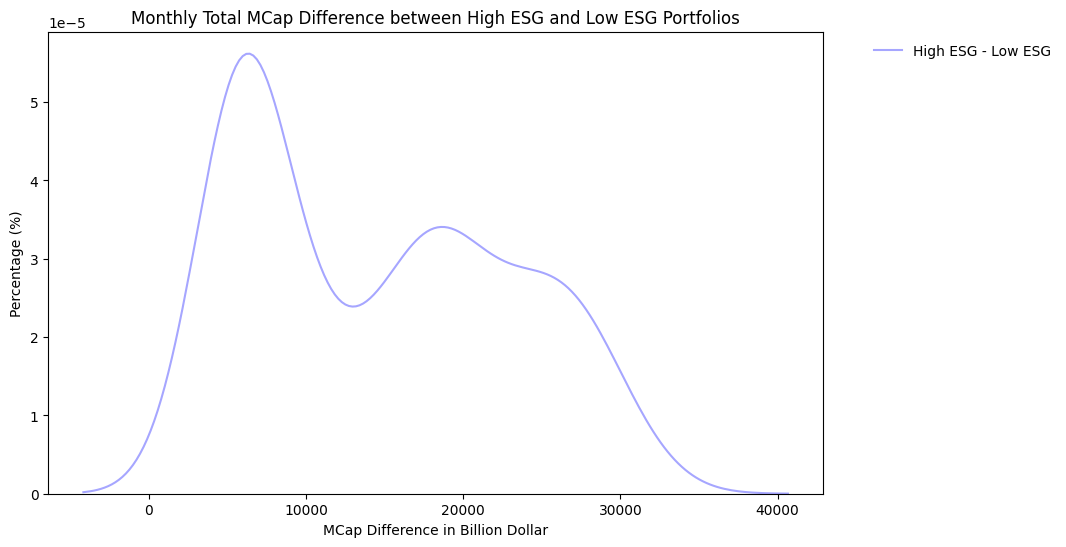

In [63]:
data_list = [esg_data_mcap_analysis]
column_names = ["Difference_Total"]
labels = ["High ESG - Low ESG"]
colors = ["blue"]

plotXReturnDistributions(data_list, column_names, labels, colors,
                           title = "Monthly Total MCap Difference between High ESG and Low ESG Portfolios",
                           x_label = "MCap Difference in Billion Dollar",
                           y_label = "Percentage (%)")

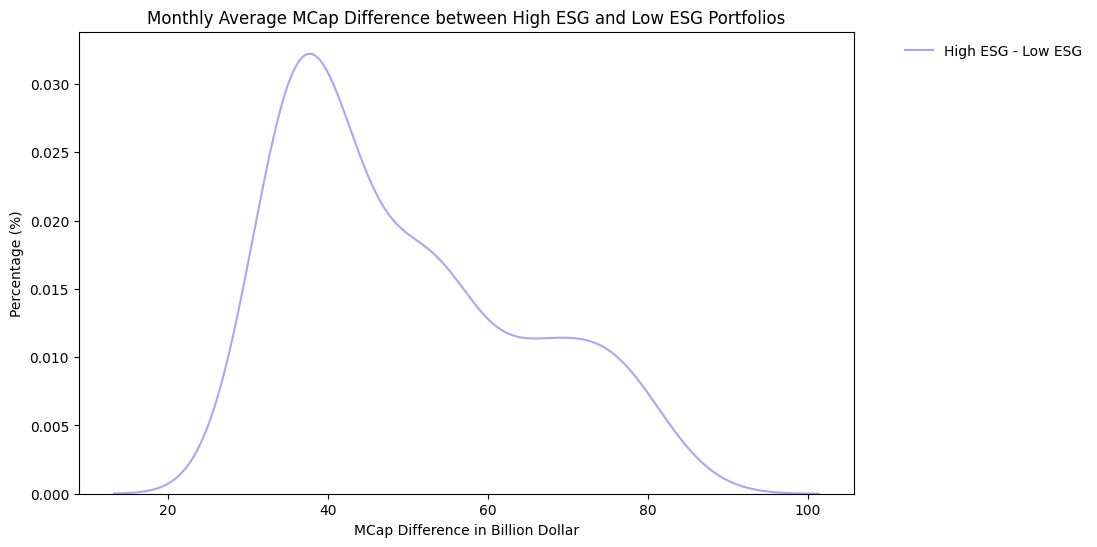

In [64]:
data_list = [esg_data_mcap_analysis]
column_names = ["Difference_Average"]
labels = ["High ESG - Low ESG"]
colors = ["blue"]

plotXReturnDistributions(data_list, column_names, labels, colors,
                           title = "Monthly Average MCap Difference between High ESG and Low ESG Portfolios",
                           x_label = "MCap Difference in Billion Dollar",
                           y_label = "Percentage (%)")

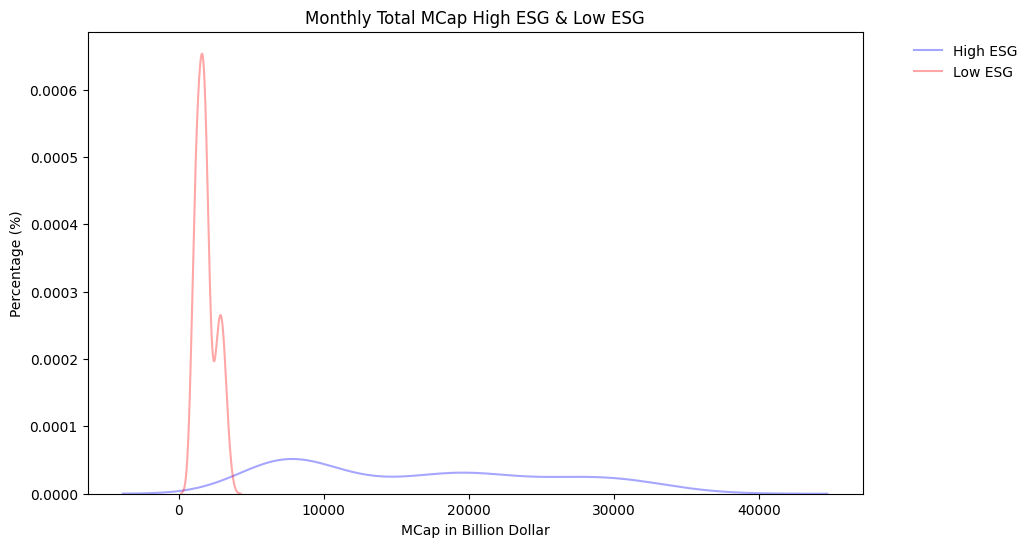

In [67]:
data_list = [esg_data_mcap_analysis, esg_data_mcap_analysis]
column_names = ["MCap_Total_High", "MCap_Total_Low"]
labels = ["High ESG", "Low ESG"]
colors = ["blue", "red"]

plotXReturnDistributions(data_list, column_names, labels, colors,
                           title = "Monthly Total MCap High ESG & Low ESG",
                           x_label = "MCap in Billion Dollar",
                           y_label = "Percentage (%)")

## **6. Fama-MacBeth Regression with Index Average ESG Factor**

The ESG factor is an equally weighted average of three esg factors constructed based on subportfolios of the entire market.

- Subportfolio 1: SPX
- Subportfolio 2: SPCY
- Subportfolio 3: SP400

### **6.1 ESG Factor Analysis**

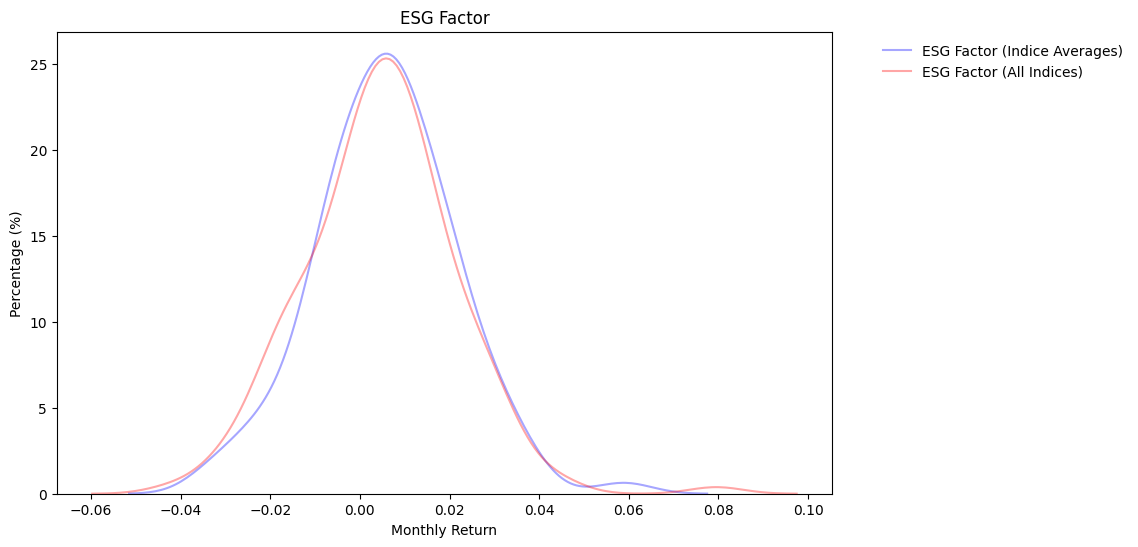

In [68]:
data_list = [esg_data_mcap_analysis, esg_data_mcap_analysis]
column_names = ["ESG_Factor_Index_Average", "ESG_Factor"]
labels = ["ESG Factor (Indice Averages)", "ESG Factor (All Indices)"]
colors = ["blue", "red"]

plotXReturnDistributions(data_list, column_names, labels, colors,
                           title = "ESG Factor",
                           x_label = "Monthly Return",
                           y_label = "Percentage (%)")

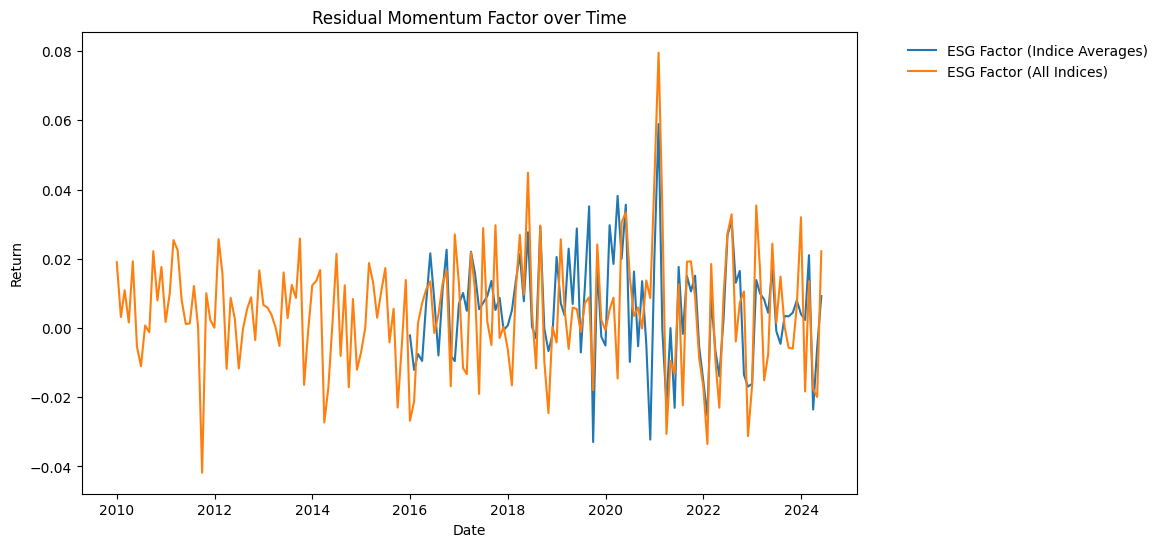

In [69]:
data_list = [esg_data_mcap_analysis, esg_data_mcap_analysis]
column_names = ["ESG_Factor_Index_Average", "ESG_Factor"]
labels = ["ESG Factor (Indice Averages)", "ESG Factor (All Indices)"]

plotXReturnsOverTime(data_list, column_names, labels, "Residual Momentum Factor over Time", "Date", "Return")

### **6.1 Visualization of Correlation of Index Average ESG Factor & Other Factors Via Heatmap**

In [70]:
esg_factors = esg_data_mcap_analysis[["Date", "ESG_Factor", "ESG_Factor_Index_Average"]]

In [71]:
momentum_factors = [res_mom_12_1, res_mom_6_1, price_mom_3_1, price_mom_6_1, price_mom_9_1, price_mom_12_1, price_mom_12_7]

dataframes = [ff5, esg_factors] + momentum_factors

for df in dataframes:
    df["Date"] = pd.to_datetime(df["Date"])

data_all_esg = reduce(lambda left, right: pd.merge(left, right, on = "Date"), dataframes)

In [72]:
data_all_esg.head()

,Date,Mkt-RF,SMB,HML,RMW,CMA,RF,ESG_Factor,ESG_Factor_Index_Average,Mom_Res_12_1_Factor,Mom_Res_6_1_Factor,Mom_Price_3_1_Factor,Mom_Price_6_1_Factor,Mom_Price_9_1_Factor,Mom_Price_12_1_Factor,Mom_Price_12_7_Factor
0,2009-12-31,0.0275,0.0624,-0.0016,0.0102,-0.0009,0.0001,0.019009,NaN,0.006155,0.000519,-0.012486,0.014146,0.023222,0.019029,0.013296
1,2010-01-31,-0.0336,0.0034,0.0043,-0.0127,0.0046,0.0000,0.003171,NaN,0.002316,0.004488,-0.030670,-0.026802,-0.028464,-0.033940,-0.018530
2,2010-02-28,0.0340,0.0151,0.0322,-0.0027,0.0142,0.0000,0.010892,NaN,0.031199,0.016779,0.031621,0.030558,0.031840,0.042727,0.028583
3,2010-03-31,0.0631,0.0185,0.0221,-0.0065,0.0169,0.0001,0.001579,NaN,0.000643,-0.003376,-0.002945,-0.011204,0.002864,0.019680,0.027442
4,2010-04-30,0.0200,0.0498,0.0289,0.0069,0.0172,0.0001,0.019267,NaN,0.003815,-0.020500,0.010361,-0.028396,-0.007668,0.003255,0.023242


In [73]:
#Calculating Correlation Coefficients

factor_columns = ["Mkt-RF", "SMB", "HML", "RMW", "CMA", "ESG_Factor", "ESG_Factor_Index_Average"]

columns_all_esg = data_all_esg[factor_columns].columns

In [74]:
#Correlation & P-Value Matrices
corr_matrix_pearson_all_esg = pd.DataFrame(index=columns_all_esg, columns=columns_all_esg, dtype=float)
pval_matrix_pearson_all_esg = pd.DataFrame(index=columns_all_esg, columns=columns_all_esg, dtype=float)

for col1 in columns_all_esg:
    for col2 in columns_all_esg:

        #If factor 1 = factor 2 then returns given values
        if col1 == col2:
          corr, pval = 1.0, 0.0
        else:

          #Drops missing values
          cleaned_data = data_all_esg[[col1, col2]].dropna()

          #Calculates correlation coefficient and p-value
          corr, pval = pearsonr(cleaned_data[col1], cleaned_data[col2])

        #Adds values to dataframes
        corr_matrix_pearson_all_esg.loc[col1, col2] = corr
        pval_matrix_pearson_all_esg.loc[col1, col2] = pval

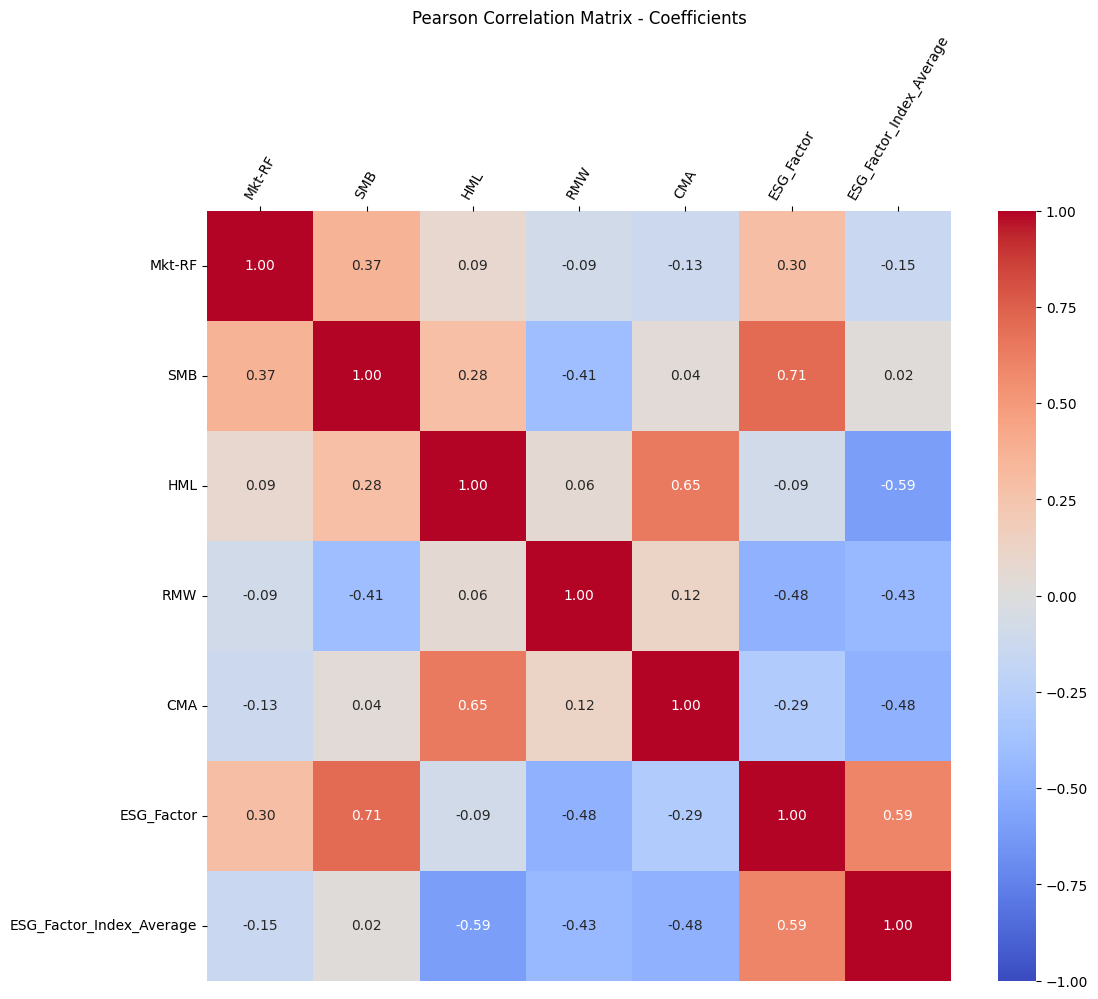

In [75]:
plotHeatmap(corr_matrix_pearson_all_esg, "Pearson Correlation Matrix - Coefficients")

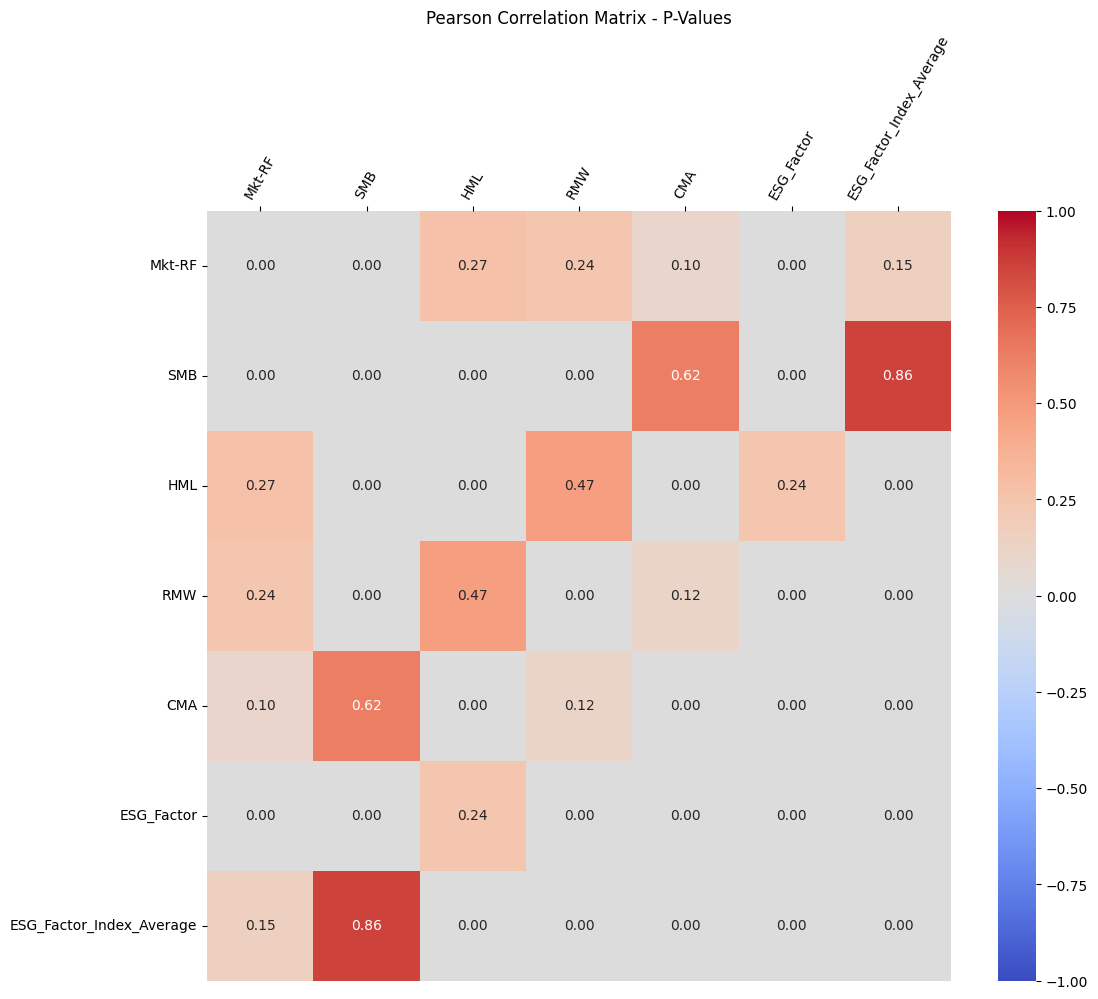

In [76]:
plotHeatmap(pval_matrix_pearson_all_esg, "Pearson Correlation Matrix - P-Values")

### **6.2 Merging & Prepping Data for Fama-MacBeth Reg.**

In [77]:
esg_factor_index_average = esg_data[["Date", "ESG_Factor_Index_Average"]]

esg_factor_index_average["Date"] = pd.to_datetime(esg_factor_index_average["Date"])
esg_factor_index_average['Date'] = esg_factor_index_average["Date"].dt.date

In [78]:
# Merge all datasets on the Date column
momentum_factors = [res_mom_12_1, res_mom_6_1, price_mom_3_1, price_mom_6_1, price_mom_9_1, price_mom_12_1, price_mom_12_7]
dataframes = [ff5, esg_factor_index_average] + momentum_factors + [stock_returns]

for df in dataframes:
    df["Date"] = pd.to_datetime(df["Date"])

#Merge data
data_esg_index_average = reduce(lambda left, right: pd.merge(left, right, on = "Date"), dataframes)

#Rename column as requirement for regression functions to work.
data_esg_index_average = data_esg_index_average.rename(columns = {"ESG_Factor_Index_Average": "ESG_Factor"})

# Display the first few rows and column names of the resulting dataframe
data_esg_index_average.tail()

,Date,Mkt-RF,SMB,HML,RMW,CMA,RF,ESG_Factor,Mom_Res_12_1_Factor,Mom_Res_6_1_Factor,...,YETI.N,YOU.N,YUM.N,ZBH.N,ZBRA.OQ,ZD.OQ,ZI.OQ,ZION.OQ,ZTS.N,ZWS.N
164,2023-08-31,-0.0239,-0.0368,-0.0108,0.0342,-0.0237,0.0045,0.003474,0.021640,0.016517,...,0.172535,-0.080293,-0.055820,-0.137749,-0.106994,-0.080943,-0.295268,-0.060973,0.012866,-0.024564
165,2023-09-30,-0.0524,-0.0179,0.0145,0.0185,-0.0084,0.0043,0.003351,0.006053,0.000538,...,-0.034635,-0.124195,-0.034318,-0.055914,-0.139922,-0.044411,-0.089900,-0.017183,-0.086767,-0.054018
166,2023-10-31,-0.0318,-0.0405,0.0019,0.0247,-0.0067,0.0047,0.004425,0.004473,-0.014745,...,-0.118208,-0.116597,-0.032656,-0.069595,-0.114573,-0.050714,-0.209756,-0.115792,-0.095442,-0.055675
167,2023-11-30,0.0883,-0.0011,0.0166,-0.0381,-0.0099,0.0044,0.007982,0.047826,0.027283,...,0.002822,0.309508,0.043727,0.113974,0.131548,0.055574,0.108796,0.168970,0.125287,0.115560
168,2023-12-31,0.0487,0.0733,0.0492,-0.0304,0.0130,0.0043,0.004055,0.000407,-0.016531,...,0.214353,-0.031880,0.040701,0.048410,0.153388,0.052805,0.286708,0.231266,0.117168,-0.001019


### **6.3 Run Regressions**

In [79]:
models_betas = runFirstStageRegression(data_esg_index_average)

In [80]:
stage_2_dataframes_ind_avg = getSecondStageDataFrames(data_esg_index_average, models_betas)

In [81]:
stage_2_dataframes_ind_avg[0].head()

,Stock,Intercept,Mkt-RF,SMB,HML,RMW,CMA,ESG_Factor,Mom_Res_12_1_Factor,Avg_Excess_Return
0,A.N,0.004073,1.164814,-0.224216,-0.034561,-0.203472,0.102589,-0.171158,0.134132,0.014073
1,AA.N,0.024613,1.732506,1.829694,0.210036,0.333019,0.096868,-3.529683,0.191564,0.020151
2,AAL.OQ,0.002707,1.082470,1.280864,0.206215,-0.099965,-0.671689,-3.050202,0.634931,0.002053
3,AAON.OQ,0.000192,0.767079,0.713462,0.026241,0.892734,0.015411,0.871941,0.438082,0.021363
4,AAP.N,-0.026410,1.060722,0.807324,0.257645,1.140665,1.318511,1.715133,-0.913702,0.007165


In [82]:
risk_premium_estimations_ind_avg, risk_premium_p_values_ind_avg = runSecondStageRegression(stage_2_dataframes_ind_avg)

### **6.4 Plots Risk Premiums in Table**

In [83]:
risk_premium_ind_avg_overview = getValueOverview(risk_premium_estimations_ind_avg)
p_value_ind_avg_overview = getValueOverview(risk_premium_p_values_ind_avg)

annualized_risk_premiums_ind_avg_overview = getAnnualizedRiskPremiums(risk_premium_ind_avg_overview)

In [84]:
monthly_risk_premium_ind_avg_table = getNiceTable(risk_premium_ind_avg_overview, "Monthly Risk Premium (Index Average ESG Factor)", "Shown in Percent (%)")
annualized_risk_premium_ind_avg_table = getNiceTable(annualized_risk_premiums_ind_avg_overview, "Annualized Risk Premium (Index Average ESG Factor)", "Shown in Percent (%)")
p_values_ind_avg_table = getNiceTable(p_value_ind_avg_overview, "P-Values (Index Average ESG Factor) of Risk Premiums", "")

In [85]:
monthly_risk_premium_ind_avg_table

GT(_tbl_data=                  Factors  Model 1  Model 2  Model 3  Model 4  Model 5  \
0                   const   0.8518   0.8934   0.7651   0.7819   0.7059   
1                  Mkt-RF   0.6266   0.5205   0.6673   0.6291   0.7226   
2                     SMB   0.1243   0.2248   0.1766   0.1995   0.1809   
3                     HML  -0.5671  -0.5488  -0.5549  -0.5256  -0.5371   
4                     RMW  -0.0670  -0.1290  -0.0833  -0.1009  -0.0707   
5                     CMA  -0.4887  -0.3954  -0.4007  -0.3754  -0.3917   
6              ESG_Factor   0.2290   0.2935   0.2714   0.2859   0.2634   
7     Mom_Res_12_1_Factor   0.2608      NaN      NaN      NaN      NaN   
8      Mom_Res_6_1_Factor      NaN   0.3421      NaN      NaN      NaN   
9    Mom_Price_3_1_Factor      NaN      NaN   0.2905      NaN      NaN   
10   Mom_Price_6_1_Factor      NaN      NaN      NaN   0.3129      NaN   
11   Mom_Price_9_1_Factor      NaN      NaN      NaN      NaN   0.4255   
12  Mom_Price_12_1_Factor      NaN      NaN      NaN      NaN      NaN   
13  Mom_Price_12_7_Factor      NaN      NaN      NaN      NaN      NaN   

    Model 6  Model 7  
0    0.7067   0.7372  
1    0.7351   0.7014  
2    0.1782   0.1892  
3   -0.5294  -0.5403  
4   -0.0766  -0.1121  
5   -0.3865  -0.3725  
6    0.2642   0.2680  
7       NaN      NaN  
8       NaN      NaN  
9       NaN      NaN  
10      NaN      NaN  
11      NaN      NaN  
12   0.3748      NaN  
13      NaN   0.0666  , _body=<great_tables._gt_data.Body object at 0x7d3b1ef798d0>, _boxhead=Boxhead([ColInfo(var='Factors', type=<ColInfoTypeEnum.default: 1>, column_label='Factors', column_align='center', column_width=None), ColInfo(var='Model 1', type=<ColInfoTypeEnum.default: 1>, column_label='Model 1', column_align='right', column_width=None), ColInfo(var='Model 2', type=<ColInfoTypeEnum.default: 1>, column_label='Model 2', column_align='right', column_width=None), ColInfo(var='Model 3', type=<ColInfoTypeEnum.default: 1>, column_label='Model 3', column_align='right', column_width=None), ColInfo(var='Model 4', type=<ColInfoTypeEnum.default: 1>, column_label='Model 4', column_align='right', column_width=None), ColInfo(var='Model 5', type=<ColInfoTypeEnum.default: 1>, column_label='Model 5', column_align='right', column_width=None), ColInfo(var='Model 6', type=<ColInfoTypeEnum.default: 1>, column_label='Model 6', column_align='right', column_width=None), ColInfo(var='Model 7', type=<ColInfoTypeEnum.default: 1>, column_label='Model 7', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x7d3b1f4b1b10>, _spanners=Spanners([]), _heading=Heading(title='Monthly Risk Premium (Index Average ESG Factor)', subtitle='Shown in Percent (%)', preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x7d3b1ef7a590>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type=

In [86]:
annualized_risk_premium_ind_avg_table

GT(_tbl_data=                  Factors  Model 1  Model 2  Model 3  Model 4  Model 5  \
0                   const    10.71    11.26     9.58     9.80     8.81   
1                  Mkt-RF     7.78     6.43     8.31     7.82     9.02   
2                     SMB     1.50     2.73     2.14     2.42     2.19   
3                     HML    -6.60    -6.39    -6.46    -6.13    -6.26   
4                     RMW    -0.80    -1.54    -1.00    -1.20    -0.85   
5                     CMA    -5.71    -4.64    -4.70    -4.41    -4.60   
6              ESG_Factor     2.78     3.58     3.31     3.49     3.21   
7     Mom_Res_12_1_Factor     3.17      NaN      NaN      NaN      NaN   
8      Mom_Res_6_1_Factor      NaN     4.18      NaN      NaN      NaN   
9    Mom_Price_3_1_Factor      NaN      NaN     3.54      NaN      NaN   
10   Mom_Price_6_1_Factor      NaN      NaN      NaN     3.82      NaN   
11   Mom_Price_9_1_Factor      NaN      NaN      NaN      NaN     5.23   
12  Mom_Price_12_1_Factor      NaN      NaN      NaN      NaN      NaN   
13  Mom_Price_12_7_Factor      NaN      NaN      NaN      NaN      NaN   

    Model 6  Model 7  
0      8.82     9.21  
1      9.19     8.75  
2      2.16     2.29  
3     -6.17    -6.29  
4     -0.92    -1.34  
5     -4.54    -4.38  
6      3.22     3.26  
7       NaN      NaN  
8       NaN      NaN  
9       NaN      NaN  
10      NaN      NaN  
11      NaN      NaN  
12     4.59      NaN  
13      NaN     0.80  , _body=<great_tables._gt_data.Body object at 0x7d3b1ef7b2e0>, _boxhead=Boxhead([ColInfo(var='Factors', type=<ColInfoTypeEnum.default: 1>, column_label='Factors', column_align='center', column_width=None), ColInfo(var='Model 1', type=<ColInfoTypeEnum.default: 1>, column_label='Model 1', column_align='right', column_width=None), ColInfo(var='Model 2', type=<ColInfoTypeEnum.default: 1>, column_label='Model 2', column_align='right', column_width=None), ColInfo(var='Model 3', type=<ColInfoTypeEnum.default: 1>, column_label='Model 3', column_align='right', column_width=None), ColInfo(var='Model 4', type=<ColInfoTypeEnum.default: 1>, column_label='Model 4', column_align='right', column_width=None), ColInfo(var='Model 5', type=<ColInfoTypeEnum.default: 1>, column_label='Model 5', column_align='right', column_width=None), ColInfo(var='Model 6', type=<ColInfoTypeEnum.default: 1>, column_label='Model 6', column_align='right', column_width=None), ColInfo(var='Model 7', type=<ColInfoTypeEnum.default: 1>, column_label='Model 7', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x7d3b1f4b19c0>, _spanners=Spanners([]), _heading=Heading(title='Annualized Risk Premium (Index Average ESG Factor)', subtitle='Shown in Percent (%)', preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x7d3b1efc80d0>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', ty

In [87]:
p_values_ind_avg_table

GT(_tbl_data=                  Factors  Model 1  Model 2  Model 3  Model 4  Model 5  \
0                   const   0.0000   0.0000   0.0000   0.0000   0.0000   
1                  Mkt-RF   0.0000   0.0000   0.0000   0.0000   0.0000   
2                     SMB   0.0051   0.0034   0.0001   0.0014   0.0003   
3                     HML   0.0000   0.0000   0.0000   0.0000   0.0000   
4                     RMW   0.1180   0.0155   0.0571   0.0415   0.1149   
5                     CMA   0.0000   0.0000   0.0000   0.0000   0.0000   
6              ESG_Factor   0.0000   0.0000   0.0000   0.0000   0.0000   
7     Mom_Res_12_1_Factor   0.0003      NaN      NaN      NaN      NaN   
8      Mom_Res_6_1_Factor      NaN   0.0000      NaN      NaN      NaN   
9    Mom_Price_3_1_Factor      NaN      NaN   0.0014      NaN      NaN   
10   Mom_Price_6_1_Factor      NaN      NaN      NaN   0.0008      NaN   
11   Mom_Price_9_1_Factor      NaN      NaN      NaN      NaN   0.0001   
12  Mom_Price_12_1_Factor      NaN      NaN      NaN      NaN      NaN   
13  Mom_Price_12_7_Factor      NaN      NaN      NaN      NaN      NaN   

    Model 6  Model 7  
0    0.0000   0.0000  
1    0.0000   0.0000  
2    0.0007   0.0040  
3    0.0000   0.0000  
4    0.0886   0.0337  
5    0.0000   0.0000  
6    0.0000   0.0000  
7       NaN      NaN  
8       NaN      NaN  
9       NaN      NaN  
10      NaN      NaN  
11      NaN      NaN  
12   0.0002      NaN  
13      NaN   0.4483  , _body=<great_tables._gt_data.Body object at 0x7d3b1efc8e20>, _boxhead=Boxhead([ColInfo(var='Factors', type=<ColInfoTypeEnum.default: 1>, column_label='Factors', column_align='center', column_width=None), ColInfo(var='Model 1', type=<ColInfoTypeEnum.default: 1>, column_label='Model 1', column_align='right', column_width=None), ColInfo(var='Model 2', type=<ColInfoTypeEnum.default: 1>, column_label='Model 2', column_align='right', column_width=None), ColInfo(var='Model 3', type=<ColInfoTypeEnum.default: 1>, column_label='Model 3', column_align='right', column_width=None), ColInfo(var='Model 4', type=<ColInfoTypeEnum.default: 1>, column_label='Model 4', column_align='right', column_width=None), ColInfo(var='Model 5', type=<ColInfoTypeEnum.default: 1>, column_label='Model 5', column_align='right', column_width=None), ColInfo(var='Model 6', type=<ColInfoTypeEnum.default: 1>, column_label='Model 6', column_align='right', column_width=None), ColInfo(var='Model 7', type=<ColInfoTypeEnum.default: 1>, column_label='Model 7', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x7d3b1f4b1b40>, _spanners=Spanners([]), _heading=Heading(title='P-Values (Index Average ESG Factor) of Risk Premiums', subtitle='', preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x7d3b1efc9bd0>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value=

## **7. Performance Metrics ESG Portfolios**

In [88]:
#Returns Risk Free Ratio (Averatge):
def getRiskFreeRate(data):
  return data["RF"].mean()

In [89]:
#Returns Average Return
def getAverageReturn(data, column):
  return data[column].mean() #Average Return

In [90]:
#Return Standard Deviation
def getStdDev(data, column):
  return data[column].std()

In [91]:
#Returns Annualized Return
def getAnnualizedReturn(data, column):
  avg_return = getAverageReturn(data, column)
  return (1 + avg_return) ** 12 - 1

In [92]:
#Returns Annualized Volatility
def getAnnualizedVolatility(data, column):
  std_return = getStdDev(data, column)
  return std_return * np.sqrt(12) #Assuming Monthly Data

In [93]:
#Returns Sharpe Ratio
def getSharpeRatio(data, column):

  average_return = getAverageReturn(data, column)
  std_dev = getStdDev(data, column)

  return (average_return - getRiskFreeRate(data)) / std_dev if std_dev != 0 else np.nan

In [94]:
#Returns Sortino Ratio
def getSortinoRatio(data, column):
  downside_returns = data[column][data[column] < 0]
  downside_deviation = np.sqrt((downside_returns**2).mean())

  average_return = getAverageReturn(data, column)

  return (average_return - getRiskFreeRate(data)) / downside_deviation if downside_deviation != 0 else np.nan


In [95]:
#Returns TreynorRatio
def getTreynorRatio(data, column):

  annualized_return = getAnnualizedReturn(data, column)
  market_return = data["Mkt-RF"].mean()

  X = sm.add_constant(data["Mkt-RF"])
  model = sm.OLS(data[column], X).fit()

  #Risk is here not the Std. Dev but beta
  beta = model.params[1]

  return (annualized_return - getRiskFreeRate(data)) / beta if beta != 0 else np.nan


In [96]:
#Returns Alpha
def getAlpha(data, column):
  market_return = data["Mkt-RF"].mean()

  X = sm.add_constant(data["Mkt-RF"])
  model = sm.OLS(data[column], X).fit()

  return model.params[0]

In [97]:
#Returns Information Ratio
def getInformationRatio(data, column):

  tracking_error = np.sqrt(((((data[column] - data["RF"]) - data["Mkt-RF"])).dropna())**2).mean()
  average_return = getAverageReturn(data, column)

  return (average_return - data["Mkt-RF"].mean()) / tracking_error if tracking_error != 0 else np.nan

In [98]:
#Returns M2 Measure (Modigliani Measure)
def getM2Measure(data, column):
  market_volatility = data["Mkt-RF"].std()
  return (getSharpeRatio(data, column) * market_volatility) + getRiskFreeRate(data)

In [99]:
round_decimals = 4

def calculatePerformanceMetrics(data, column):
  print(f"\nPerformance Metrics for {column}:")
  print(f"1. Annualized Return: {round(getAnnualizedReturn(data, column), round_decimals)}")
  print(f"2. Annualized Volatility: {round(getAnnualizedVolatility(data, column), round_decimals)}")
  print(f"3. Sharpe Ratio: {round(getSharpeRatio(data, column), round_decimals)}")
  print(f"4. Sortino Ratio: {round(getSortinoRatio(data, column), round_decimals)}")
  print(f"5. Treynor Ratio: {round(getTreynorRatio(data, column), round_decimals)}")
  print(f"6. Alpha: {round(getAlpha(data, column), round_decimals)}")
  print(f"7. Information Ratio: {round(getInformationRatio(data, column), round_decimals)}")
  print(f"8. M2 Measure: {round(getM2Measure(data, column), round_decimals)}")

In [100]:
portfolios = ['low_esg', 'high_esg']

metrics = [calculatePerformanceMetrics(regression_data, f"return_{portfolio}") for portfolio in portfolios]
metrics


Performance Metrics for return_low_esg:
1. Annualized Return: 0.215
2. Annualized Volatility: 0.1915
3. Sharpe Ratio: 0.2832
4. Sortino Ratio: 0.2812
5. Treynor Ratio: 0.1836
6. Alpha: 0.004
7. Information Ratio: 0.369
8. M2 Measure: 0.0133

Performance Metrics for return_high_esg:
1. Annualized Return: 0.1481
2. Annualized Volatility: 0.1689
3. Sharpe Ratio: 0.223
4. Sortino Ratio: 0.2108
5. Treynor Ratio: 0.1397
6. Alpha: 0.0004
7. Information Ratio: 0.1025
8. M2 Measure: 0.0106


[None, None]